In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
from itertools import chain
import glob
import seaborn as sns
import matplotlib.font_manager as font_manager
import seaborn as sns
import matplotlib as mpl
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from collections import Counter
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import register_matplotlib_converters
import warnings
import itertools
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
register_matplotlib_converters()

In [2]:
sns.set_theme()
mpl.matplotlib_fname()
font_dirs = ['D:\\Software\\Anaconda\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf' ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
mpl.font_manager._rebuild()
result = font_manager.findfont("Rounded Mplus 1c")
print(result)
mpl.rc('font', family='Rounded Mplus 1c')

D:\Software\Anaconda\Lib\site-packages\matplotlib\mpl-data\fonts\ttf\MPLUSRounded1c-Regular.ttf


In [3]:
def extract_engine_data (description, list_em):
    engine_model = []
    for e in list_em:
        em_reg = re.findall(r'\b{}-\w+-?\w*\b'.format(e), description)
        if len(em_reg) != 0 :
          em_reg = map(lambda x : x.split('-')[0],em_reg)
#           em_reg = list(set(em_reg)) 
          engine_model.append(em_reg)
    if len(engine_model) != 0:
      return list(chain(*engine_model))
    else: 
      return 0

def normalize_zero (row,unit_price):
    if row['Quantity'] == 0:
      if row['Cargo Value USD'] % unit_price < 2:
        return 1
      else:
        return row['Cargo Value USD'] // unit_price
    else:
        return row['Quantity']
    

def check_count_em (row,unit_price):
    if (row['count_em'] == 1) and (row['len_em'] > 1):
       if (row['Cargo Value USD'] < unit_price) or (row['Cargo Value USD'] == unit_price):
         return  round(row['Cargo Value USD']/row['len_em'],2)
       else:
         return unit_price

    elif (row['count_em'] > 1) and (row['len_em'] > 1):
        if (row['Cargo Value USD'] < row['count_em'] * unit_price) or (row['Cargo Value USD'] == row['count_em'] * unit_price):
           return  round(row['Cargo Value USD']/row['Quantity'],2)
#         elif row['Cargo Value USD'] > row['count_em'] * 266.77
#              return  round(row['Cargo Value USD']/row['len_em'],2)
        else:
            return row['count_em'] * unit_price
#             return  round(row['Cargo Value USD']/row['Quantity']*row['count_em'],2)
    elif ((row['count_em'] ==1) and (row['len_em'] == 1)):
       return  round(row['Cargo Value USD']/row['len_em'],2)
    else:
       return row['Cargo Value USD']



def count_length(list_em,em):
    count  = 0
    for i in list_em:
        if i == em:
            count+=1
    return count

In [4]:
# Load list all engine model in GTO
# df_merged = read_csv('list_all_em_GTO.csv',parse_dates=['Register Date'])
df_merged = read_csv('list_all_em_GTO.csv')
df_merged['Register Date'] = pd.to_datetime(df_merged['Register Date'],format='%Y-%m-%d')
df_merged.drop('Unnamed: 0',axis=1,inplace=True)
df_merged.head()

,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,Shipper Address,Consignee,Consignee Address,Quantity,Unit of Measure,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD
0,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-261 В РАЗОБРАННО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,"450-8575 NAKAMURA-KU NAGOYA 9-8,MEIEKI 4-CHOME",ООО ТЕХНОСЕРВИСПРОМ,"603104, НИЖЕГОРОДСКАЯ ОБЛ, Н.НОВГОРОД, НАРТОВА...",15,ШТ,CIF,3604.0,3017.0,73063.36
1,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-A343E-111 В РАЗО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,"450-8575 NAKAMURA-KU NAGOYA 9-8,MEIEKI 4-CHOME",ООО ТЕХНОСЕРВИСПРОМ,"603104, НИЖЕГОРОДСКАЯ ОБЛ, Н.НОВГОРОД, НАРТОВА...",5,ШТ,CIF,1765.0,1465.0,37014.64
2,2011-01-17,8407343009,"ДВИГАТЕЛЬ ЗИЛ ,Б/У,БЕНЗИНОВЫЙ,ОБЪЕМ 6000СМ.КУБ...",АМО ЗИЛ,ЗИЛ,ЕКАТЕРИНБУРГ,"RU, RUS, Russia","UA, UKR, Ukraine",ООО ПЕТРУС,"Г.ДРОГОБЫЧ УЛ.ГАЙДАМАЦКАЯ, 7/1",ЗАО АВТОМОБИЛИ И МОТОРЫ УРАЛА,"624130, СВЕРДЛОВСКАЯ ОБЛ., Г.НОВОУРАЛЬСК, УЛ.А...",30,ШТ,CPT,14400.0,14400.0,27000.00
3,2011-01-17,8407343009,"ДВИГАТЕЛЬ ЗИЛ ,Б/У,НЕКОМПЛЕКТНЫЙ,БЕНЗИНОВЫЙ,ОБ...",АМО ЗИЛ,ЗИЛ,ЕКАТЕРИНБУРГ,"RU, RUS, Russia","UA, UKR, Ukraine",ООО ПЕТРУС,"Г.ДРОГОБЫЧ УЛ.ГАЙДАМАЦКАЯ, 7/1",ЗАО АВТОМОБИЛИ И МОТОРЫ УРАЛА,"624130, СВЕРДЛОВСКАЯ ОБЛ., Г.НОВОУРАЛЬСК, УЛ.А...",15,ШТ,CPT,3000.0,3000.0,6894.50
4,2011-01-20,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ В СБОРЕ С КОРОБКОЙ ПЕРЕДА...,MERCEDES - BENZ,MERCEDES - BENZ,ТОЯМА НЬЮ ПОРТ,"JP, JPN, Japan","JP, JPN, Japan","METAL AUTO HOKURIKU CO., LTD","ISHIKAWA KEN KOMATSU SHI SHIRAE MACHI, RO 62",ИП КОЧЕТКОВ ВЯЧЕСЛАВ ВИКТОРОВИЧ,"664019, , Г ИРКУТСК, ПЕР. МИНУСИНСКИЙ Д 10",38,ШТ,FOB,6460.0,6460.0,6536.45


In [5]:
for col in list(df_merged.columns):
 (df_merged[col].dtype ==  'object') and (df_merged[col].fillna(value='unknown',inplace = True)) or (df_merged[col].fillna(value=0, inplace = True))

In [6]:
# Load list engine model
df_list_engine = pd.read_excel('Engine Model _1025.xlsx')
df_list_engine.head()

,Unnamed: 0,メーカー,燃料,買付受付,型式,駆動1,駆動2,駆動3,詳細,車輌型式,KRA売単価,車名,仕入値,EG売価\n（マニ触付）\nW,EG売価\n（マニ触抜/無）\nWO
0,2.0,FIAT,0,×,4,FR,AT,2WD,NaN,NaN,NaN,NaN,NaN,売価確認,売価確認
1,3.0,PORCHE,NaN,×,64,RR,AT,4WD,NaN,NaN,NaN,NaN,NaN,売価確認,0
2,4.0,PORCHE,NaN,×,66,RR,MT,2WD,NaN,NaN,NaN,NaN,NaN,売価確認,0
3,5.0,PORCHE,NaN,×,70,RR,AT,4WD,NaN,NaN,NaN,NaN,NaN,売価確認,0
4,6.0,BENZ,NaN,○,102,FR,AT,2WD,NaN,NaN,NaN,NaN,NaN,40000,0


In [7]:
# Load list engine TOYOTA
df_brand_toyota =  df_list_engine[df_list_engine['メーカー']  == 'TOYOTA']
list_toyota = list(df_brand_toyota['型式'].unique())
list_toyota  = list(map(lambda x: x.split('-')[0],list_toyota))
list_toyota  = list(set(list_toyota))

In [8]:
df_brand_mazda =  df_list_engine[df_list_engine['メーカー']  == 'MAZDA']
list_mazda = list(df_brand_mazda['型式'].unique())
list_mazda  = list(map(lambda x: x.split('-')[0],list_mazda))
list_mazda  = list(set(list_mazda))

In [9]:
df_brand_mitsubishi =  df_list_engine[df_list_engine['メーカー']  == 'MITSUBISHI']
list_mitsubishi = list(df_brand_mitsubishi['型式'].unique())
list_mitsubishi  = list(map(lambda x: x.split('-')[0],list_mitsubishi))
list_mitsubishi  = list(set(list_mitsubishi))

In [10]:
df_brand_honda =  df_list_engine[df_list_engine['メーカー']  == 'HONDA']
list_honda = list(df_brand_honda['型式'].unique())
list_honda  = list(map(lambda x: x.split('-')[0],list_honda))
list_honda  = list(set(list_honda))

In [11]:
df_brand_nissan =  df_list_engine[df_list_engine['メーカー']  == 'NISSAN']
list_nissan = list(df_brand_nissan['型式'].unique())
list_nissan  = list(map(lambda x: x.split('-')[0],list_nissan))
list_nissan  = list(set(list_nissan))

In [12]:
df_brand_subaru =  df_list_engine[df_list_engine['メーカー']  == 'SUBARU']
list_subaru = list(df_brand_subaru['型式'].unique())
list_subaru  = list(map(lambda x: x.split('-')[0],list_subaru))
list_subaru  = list(set(list_subaru))

# Extract list engine of each brand

In [13]:
df_toyota_GTO = df_merged[df_merged.Producer.str.contains('TOYOTA')]
df_toyota_GTO['extracted_engine']  = df_toyota_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_toyota))
df_toyota_GTO['brand'] = 'TOYOTA'
df_toyota_GTO_extracted_em = df_toyota_GTO[df_toyota_GTO['extracted_engine'] !=0]

<ipython-input-13-2c10ef0cfc14>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_toyota_GTO['extracted_engine']  = df_toyota_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_toyota))
<ipython-input-13-2c10ef0cfc14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_toyota_GTO['brand'] = 'TOYOTA'


In [14]:
df_mazda_GTO = df_merged[df_merged.Producer.str.contains('MAZDA')]
df_mazda_GTO['brand'] = 'MAZDA'
df_mazda_GTO['extracted_engine']  = df_mazda_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_mazda))
df_mazda_GTO_extracted_em = df_mazda_GTO[df_mazda_GTO['extracted_engine'] !=0]

<ipython-input-14-55b0c9e7ffc8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mazda_GTO['brand'] = 'MAZDA'
<ipython-input-14-55b0c9e7ffc8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mazda_GTO['extracted_engine']  = df_mazda_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_mazda))


In [15]:
df_mitsubishi_GTO = df_merged[df_merged.Producer.str.contains('MITSUBISHI')]
df_mitsubishi_GTO['brand'] = 'MITSUBISHI'
df_mitsubishi_GTO['extracted_engine']  = df_mitsubishi_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_mitsubishi))
df_mitsubishi_GTO_extracted_em = df_mitsubishi_GTO[df_mitsubishi_GTO['extracted_engine'] !=0]

<ipython-input-15-a3695c5d34da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mitsubishi_GTO['brand'] = 'MITSUBISHI'
<ipython-input-15-a3695c5d34da>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mitsubishi_GTO['extracted_engine']  = df_mitsubishi_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_mitsubishi))


In [16]:
df_mitsubishi_GTO_extracted_em

,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,Shipper Address,Consignee,Consignee Address,Quantity,Unit of Measure,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,brand,extracted_engine
12,2011-01-18,8407343009,"ДВС ОТ А/М, Б/У, В СБОРЕ С КПП, БЕНЗИН: HONDA,...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, SUZU...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, SUZU...",КОБЕ,"JP, JPN, Japan","JP, JPN, Japan","J-TRADE CO., LTD","614-8051 КЙОТО ЯВАТА-СИТИ ЯВАТА-ЯМАДА, 67-3",ИП КАРПЕНОК НАТАЛЬЯ ГЕННАДЬЕВНА,"690105, ПРИМОРСКИЙ КРАЙ, Г. ВЛАДИВОСТОК, УЛ. Р...",22,ШТ,FOB,5500.0,5500.0,3339.77,MITSUBISHI,[4G93]
22,2011-01-27,8407343009,"ДВС ОТ А/М, Б/У, В СБОРЕ С КПП, БЕНЗИН: HONDA,...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, TOYOTA","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, TOYOTA",КОБЕ,"JP, JPN, Japan","JP, JPN, Japan","J-TRADE CO., LTD","614-8051 КЙОТО ЯВАТА-СИТИ ЯВАТА-ЯМАДА, 67-3",КАРПЕНОК НАТАЛЬЯ ГЕНАДЬЕВНА ПАСПОРТ 0503№28165...,"690105, ПРИМОРСКИЙ КРАЙ, ВЛАДИВОСТОК, РУССКАЯ ...",19,ШТ,FOB,4750.0,4750.0,2867.72,MITSUBISHI,"[6G73, 6G73]"
45,2011-01-13,8407343009,"ДВИГАТЕЛЬ БЕНЗИН.ДЛЯ ЛЕГ.А/М,Б/У,ЯП.ПР-ВА В СБ...","NISSAN, MITSUBISHI,TOYOTA,MAZDA,HONDA,SUBARU,D...","NISSAN, MITSUBISHI, TOYOTA,MAZDA,SUBARU,HONDA,...",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",LEEA CORPORATION,"HIROSHIMA TAKAYADAI 2-CHOME, 1-8",ООО РДС-АВТО,"690066, ПРИМОРСКИЙ КРАЙ, ВЛАДИВОСТОК, УЛ.ШИЛКИ...",35,ШТ,CFR,10255.0,10255.0,6160.00,MITSUBISHI,[4G93]
55,2011-01-14,8407343009,"ДВИГАТЕЛЬ БЕНЗИНОВЫЙ, БЫВШИЙ В УПОТРЕБЛЕНИИ, Д...","TOYOTA, HONDA, MAZDA, NISSAN, MITSUBISHI","TOYOTA, HONDA, MAZDA, NISSAN, MITSUBISHI",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","HIKARI SYOJI CO.,LTD","KYOTO YAWATA-CITY 27, YAWATAKUBOTA",САКУРА МОТОРС КЕМЕРОВО ООО,"650010, КЕМЕРОВСКАЯ ОБЛАСТЬ, КЕМЕРОВО, МАЯКОВС...",34,ШТ,CFR,7235.0,7235.0,3945.00,MITSUBISHI,[4G93]
91,2011-01-21,8407343009,"ЗАП.ЧАСТИ ДЛЯ А/М, Б/У ДВИГАТЕЛЯ С АКП ЯПОНСКО...","TOYOTA,MITSUBISHI,SUBARU","TOYOTA,MITSUBISHI,SUBARU",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","АВТОЛОМ ДЖАПАН КО.,ЛТД","17-1 ДЖАПАН ПУСАН НИШИДЕГУЧИ,АЗА 16 ХАСУГАУРА,...",ООО ДВ-МОТОРС,"690065, ПРИМОРСКИЙ КРАЙ, Г. ВЛАДИВОСТОК, УЛ. С...",3,ШТ,CFR,600.0,600.0,480.00,MITSUBISHI,[4G15]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258988,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ А/М БЫВШИЙ В УПОТРЕБЛ...,MITSUBISHI SUBARU SUZUKI,MITSUBISHI SUBARU SUZUKI,TOYAMASHINKO,"JP, JPN, Japan","JP, JPN, Japan",FESCO INTEGRATED TRANSPORY LLC O/B OF KAIHO IN...,"920-0209, ISHIKAWA KEN, KANAZAWA-SHI, 1-25 HIG...",ООО АВТОСТОК,"630088, ГОРОД НОВОСИБИРСК, СЕВЕРНЫЙ ПРОЕЗД, Д ...",0,unknown,FOB,2125.0,2070.0,3133.66,MITSUBISHI,"[4G94, 4G93]"
259055,2019-12-01,8407343009,"ДВИГАТЕЛЬ ОТ А/М Б/У С АКП ,БЕНЗИНОВЫЙ ОБЪЕМОМ...",MITSUBISHI,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",UNICO CO LTD,"ЯПОНИЯ, ЙОКОГАМА, АСОНА, БИЗИН 926-3",ИП МАТВЕЕВ СТАНИСЛАВ ВАЛЕРЬЕВИЧ,"630000, ГОРОД НОВОСИБИРСК",0,unknown,CFR,467.0,467.0,706.00,MITSUBISHI,[4G93]
259068,2019-12-01,8407343009,ДВИГАТЕЛИ-2ШТ.БЫВШ.В УПОТР.КАРБЮРАТ.ОБЪЕМ 1834...,MITSUBISHI MOTOR CO.,MITSUBISHI,ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",SUNTEC CO. LTD.,"KIYOSE-CITY, TOKYO, 6-95-1-105 NAKAZATO",ИП ФОМИЧЕВ АЛЕКСАНДР ИВАНОВИЧ,"630000, ГОРОД НОВОСИБИРСК",0,unknown,CFR,460.0,460.0,720.70,MITSUBISHI,"[4G93, 4G63]"
259138,2019-12-01,8407343009,ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЫВШИЕ В УПОТРЕ...,FUJI HEAVY INDUSTRIES CO.LTDMITSUBISHI MOTORS ...,SUBARUMITSUBISHI,ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",WEST-JAPAN AUTO RECYCLE CO.LTD (WARC),"1-62, FUKUOKA, KITAKYUSHU, HIBIKIMACHI, WAKAMA...",ООО ПАРУС,"650040, 650040, ОБЛАСТЬ КЕМЕРОВСКАЯ ОБЛАСТЬ - ...",0,unknown,CFR,760.0,760.0,1148.61,MITSUBISHI,[6G73]


In [17]:
df_honda_GTO = df_merged[df_merged.Producer.str.contains('HONDA')]
df_honda_GTO['brand'] = 'HONDA'
df_honda_GTO['extracted_engine']  = df_honda_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_honda))
df_honda_GTO_extracted_em = df_honda_GTO[df_honda_GTO['extracted_engine'] !=0]

<ipython-input-17-0c8c0f52b4a5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_honda_GTO['brand'] = 'HONDA'
<ipython-input-17-0c8c0f52b4a5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_honda_GTO['extracted_engine']  = df_honda_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_honda))


In [18]:
df_nissan_GTO = df_merged[df_merged.Producer.str.contains('NISSAN')]
df_nissan_GTO['brand'] = 'NISSAN'
df_nissan_GTO['extracted_engine']  = df_nissan_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_nissan))
df_nissan_GTO_extracted_em = df_nissan_GTO[df_nissan_GTO['extracted_engine'] !=0]

<ipython-input-18-edd9724bdd48>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nissan_GTO['brand'] = 'NISSAN'
<ipython-input-18-edd9724bdd48>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nissan_GTO['extracted_engine']  = df_nissan_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_nissan))


In [19]:
df_subaru_GTO = df_merged[df_merged.Producer.str.contains('SUBARU')]
df_subaru_GTO['brand'] = 'SUBARU'
df_subaru_GTO['extracted_engine']  = df_subaru_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_subaru))
df_subaru_GTO_extracted_em = df_subaru_GTO[df_subaru_GTO['extracted_engine'] != 0]

<ipython-input-19-72adf53e9231>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subaru_GTO['brand'] = 'SUBARU'
<ipython-input-19-72adf53e9231>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subaru_GTO['extracted_engine']  = df_subaru_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_subaru))


In [20]:
list_brand  = [df_toyota_GTO_extracted_em,df_mazda_GTO_extracted_em,df_mitsubishi_GTO_extracted_em,df_honda_GTO_extracted_em,df_nissan_GTO_extracted_em,df_subaru_GTO_extracted_em]
df_all = pd.concat(list_brand)

In [21]:
df_all['extracted_engine'] = df_all.extracted_engine.map(tuple)
df_all.drop_duplicates()

,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,Shipper Address,Consignee,Consignee Address,Quantity,Unit of Measure,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand
0,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-261 В РАЗОБРАННО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,"450-8575 NAKAMURA-KU NAGOYA 9-8,MEIEKI 4-CHOME",ООО ТЕХНОСЕРВИСПРОМ,"603104, НИЖЕГОРОДСКАЯ ОБЛ, Н.НОВГОРОД, НАРТОВА...",15,ШТ,CIF,3604.0,3017.0,73063.36,"(2TR, 2TR)",TOYOTA
1,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-A343E-111 В РАЗО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,"450-8575 NAKAMURA-KU NAGOYA 9-8,MEIEKI 4-CHOME",ООО ТЕХНОСЕРВИСПРОМ,"603104, НИЖЕГОРОДСКАЯ ОБЛ, Н.НОВГОРОД, НАРТОВА...",5,ШТ,CIF,1765.0,1465.0,37014.64,"(2TR, 2TR)",TOYOTA
6,2011-01-06,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,1JZ-0...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД","910-0049 ФУКУИ-КЕН ФУКУИ-ШИ ФУКАДАНИ-ЧО, 1-7-3",НИКА ВЭД ООО,"690002, ПРИМОРСКИЙ КРАЙ, Г.ВЛАДИВОСТОК, НЕКРАС...",1,ШТ,CFR,150.0,150.0,120.00,"(1JZ,)",TOYOTA
10,2011-01-13,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД","910-0049 ФУКУИ-КЕН ФУКУИ-ШИ ФУКАДАНИ-ЧО, 1-7-3",НИКА ВЭД ООО,"690002, ПРИМОРСКИЙ КРАЙ, Г.ВЛАДИВОСТОК, НЕКРАС...",3,ШТ,CFR,450.0,450.0,360.00,"(5K, 2TR, 2UZ)",TOYOTA
11,2011-01-17,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД","910-0049 ФУКУИ-КЕН ФУКУИ-ШИ ФУКАДАНИ-ЧО, 1-7-3",НИКА ВЭД ООО,"690002, ПРИМОРСКИЙ КРАЙ, Г.ВЛАДИВОСТОК, НЕКРАС...",3,ШТ,CFR,450.0,450.0,360.00,"(5K, 2TR, 2UZ)",TOYOTA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258909,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,"HOKKAIDO, HIGASHITAKASU ASAHIKAWA, 2149-13, HI...",ООО ВКС,"690002, ГОРОД ВЛАДИВОСТОК, ПР-КТ КРАСНОГО ЗНАМ...",0,unknown,CFR,200.0,200.0,302.00,"(EJ20,)",SUBARU
258910,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,"HOKKAIDO, HIGASHITAKASU ASAHIKAWA, 2149-13, HI...",ООО ВКС,"690002, ГОРОД ВЛАДИВОСТОК, ПР-КТ КРАСНОГО ЗНАМ...",0,unknown,CFR,200.0,200.0,302.00,"(EJ20,)",SUBARU
258942,2019-12-01,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU CORPORATION,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",AL EXPORT,"875-1, KAMONOFU, SINGU, FUKUOKA PREF, KASUYA",ООО КАСТОМ-ВЛ,"690003, ГОРОД ВЛАДИВОСТОК, УЛ НИЖНЕПОРТОВАЯ, Д...",0,unknown,CFR,220.0,220.0,332.20,"(EJ20,)",SUBARU
258988,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ А/М БЫВШИЙ В УПОТРЕБЛ...,MITSUBISHI SUBARU SUZUKI,MITSUBISHI SUBARU SUZUKI,TOYAMASHINKO,"JP, JPN, Japan","JP, JPN, Japan",FESCO INTEGRATED TRANSPORY LLC O/B OF KAIHO IN...,"920-0209, ISHIKAWA KEN, KANAZAWA-SHI, 1-25 HIG...",ООО АВТОСТОК,"630088, ГОРОД НОВОСИБИРСК, СЕВЕРНЫЙ ПРОЕЗД, Д ...",0,unknown,FOB,2125.0,2070.0,3133.66,"(EJ15,)",SUBARU


In [22]:
df_all['extracted_engine'] = df_all.extracted_engine.map(list)

In [23]:
df_copy = df_all.copy().reset_index()
df_copy['month_year'] = df_copy['Register Date'].dt.strftime('%Y-%m')
df_copy['year'] =  df_copy['Register Date'].dt.strftime('%Y')
df_copy['len_unique_em'] = df_copy['extracted_engine'].map(lambda x : len(set(x)))
df_copy['len_em'] = df_copy['extracted_engine'].map(lambda x : len(x))
df_copy

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em
0,0,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-261 В РАЗОБРАННО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,...,CIF,3604.0,3017.0,73063.36,"[2TR, 2TR]",TOYOTA,2011-01,2011,1,2
1,1,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-A343E-111 В РАЗО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,...,CIF,1765.0,1465.0,37014.64,"[2TR, 2TR]",TOYOTA,2011-01,2011,1,2
2,6,2011-01-06,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,1JZ-0...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД",...,CFR,150.0,150.0,120.00,[1JZ],TOYOTA,2011-01,2011,1,1
3,10,2011-01-13,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД",...,CFR,450.0,450.0,360.00,"[5K, 2TR, 2UZ]",TOYOTA,2011-01,2011,3,3
4,11,2011-01-17,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД",...,CFR,450.0,450.0,360.00,"[5K, 2TR, 2UZ]",TOYOTA,2011-01,2011,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43878,258910,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,...,CFR,200.0,200.0,302.00,[EJ20],SUBARU,2019-12,2019,1,1
43879,258942,2019-12-01,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU CORPORATION,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",AL EXPORT,...,CFR,220.0,220.0,332.20,[EJ20],SUBARU,2019-12,2019,1,1
43880,258988,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ А/М БЫВШИЙ В УПОТРЕБЛ...,MITSUBISHI SUBARU SUZUKI,MITSUBISHI SUBARU SUZUKI,TOYAMASHINKO,"JP, JPN, Japan","JP, JPN, Japan",FESCO INTEGRATED TRANSPORY LLC O/B OF KAIHO IN...,...,FOB,2125.0,2070.0,3133.66,[EJ15],SUBARU,2019-12,2019,1,1
43881,259059,2019-12-01,8407343009,"ДВИГАТЕЛЬ ОТ А/М Б/У С АКП ,БЕНЗИНОВЫЙ ОБЪЕМОМ...",SUBARU DAIHATSU,SUBARU DAIHATSU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",UNICO CO LTD,...,CFR,383.0,383.0,578.00,[FB20],SUBARU,2019-12,2019,1,1


In [24]:
df_copy[df_copy.brand == 'MITSUBISHI']

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em
24123,12,2011-01-18,8407343009,"ДВС ОТ А/М, Б/У, В СБОРЕ С КПП, БЕНЗИН: HONDA,...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, SUZU...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, SUZU...",КОБЕ,"JP, JPN, Japan","JP, JPN, Japan","J-TRADE CO., LTD",...,FOB,5500.0,5500.0,3339.77,[4G93],MITSUBISHI,2011-01,2011,1,1
24124,22,2011-01-27,8407343009,"ДВС ОТ А/М, Б/У, В СБОРЕ С КПП, БЕНЗИН: HONDA,...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, TOYOTA","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, TOYOTA",КОБЕ,"JP, JPN, Japan","JP, JPN, Japan","J-TRADE CO., LTD",...,FOB,4750.0,4750.0,2867.72,"[6G73, 6G73]",MITSUBISHI,2011-01,2011,1,2
24125,45,2011-01-13,8407343009,"ДВИГАТЕЛЬ БЕНЗИН.ДЛЯ ЛЕГ.А/М,Б/У,ЯП.ПР-ВА В СБ...","NISSAN, MITSUBISHI,TOYOTA,MAZDA,HONDA,SUBARU,D...","NISSAN, MITSUBISHI, TOYOTA,MAZDA,SUBARU,HONDA,...",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",LEEA CORPORATION,...,CFR,10255.0,10255.0,6160.00,[4G93],MITSUBISHI,2011-01,2011,1,1
24126,55,2011-01-14,8407343009,"ДВИГАТЕЛЬ БЕНЗИНОВЫЙ, БЫВШИЙ В УПОТРЕБЛЕНИИ, Д...","TOYOTA, HONDA, MAZDA, NISSAN, MITSUBISHI","TOYOTA, HONDA, MAZDA, NISSAN, MITSUBISHI",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","HIKARI SYOJI CO.,LTD",...,CFR,7235.0,7235.0,3945.00,[4G93],MITSUBISHI,2011-01,2011,1,1
24127,91,2011-01-21,8407343009,"ЗАП.ЧАСТИ ДЛЯ А/М, Б/У ДВИГАТЕЛЯ С АКП ЯПОНСКО...","TOYOTA,MITSUBISHI,SUBARU","TOYOTA,MITSUBISHI,SUBARU",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","АВТОЛОМ ДЖАПАН КО.,ЛТД",...,CFR,600.0,600.0,480.00,[4G15],MITSUBISHI,2011-01,2011,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30275,258988,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ А/М БЫВШИЙ В УПОТРЕБЛ...,MITSUBISHI SUBARU SUZUKI,MITSUBISHI SUBARU SUZUKI,TOYAMASHINKO,"JP, JPN, Japan","JP, JPN, Japan",FESCO INTEGRATED TRANSPORY LLC O/B OF KAIHO IN...,...,FOB,2125.0,2070.0,3133.66,"[4G94, 4G93]",MITSUBISHI,2019-12,2019,2,2
30276,259055,2019-12-01,8407343009,"ДВИГАТЕЛЬ ОТ А/М Б/У С АКП ,БЕНЗИНОВЫЙ ОБЪЕМОМ...",MITSUBISHI,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",UNICO CO LTD,...,CFR,467.0,467.0,706.00,[4G93],MITSUBISHI,2019-12,2019,1,1
30277,259068,2019-12-01,8407343009,ДВИГАТЕЛИ-2ШТ.БЫВШ.В УПОТР.КАРБЮРАТ.ОБЪЕМ 1834...,MITSUBISHI MOTOR CO.,MITSUBISHI,ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",SUNTEC CO. LTD.,...,CFR,460.0,460.0,720.70,"[4G93, 4G63]",MITSUBISHI,2019-12,2019,2,2
30278,259138,2019-12-01,8407343009,ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЫВШИЕ В УПОТРЕ...,FUJI HEAVY INDUSTRIES CO.LTDMITSUBISHI MOTORS ...,SUBARUMITSUBISHI,ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",WEST-JAPAN AUTO RECYCLE CO.LTD (WARC),...,CFR,760.0,760.0,1148.61,[6G73],MITSUBISHI,2019-12,2019,1,1


In [25]:
# Toyota :3S ( 11467＝14.75%), 1NZ (9912＝12.75%) , 1G ( 8744 ＝ 11.25%)

# Mitsubishi : EM =  4G93

In [420]:
# df_copy.extracted_engine.map(list)
df_3s  = df_copy[df_copy["extracted_engine"].apply(lambda x : '4G93' in x)]
df_3s

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em
24123,12,2011-01-18,8407343009,"ДВС ОТ А/М, Б/У, В СБОРЕ С КПП, БЕНЗИН: HONDA,...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, SUZU...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, SUZU...",КОБЕ,"JP, JPN, Japan","JP, JPN, Japan","J-TRADE CO., LTD",...,FOB,5500.0,5500.0,3339.77,[4G93],MITSUBISHI,2011-01,2011,1,1
24125,45,2011-01-13,8407343009,"ДВИГАТЕЛЬ БЕНЗИН.ДЛЯ ЛЕГ.А/М,Б/У,ЯП.ПР-ВА В СБ...","NISSAN, MITSUBISHI,TOYOTA,MAZDA,HONDA,SUBARU,D...","NISSAN, MITSUBISHI, TOYOTA,MAZDA,SUBARU,HONDA,...",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",LEEA CORPORATION,...,CFR,10255.0,10255.0,6160.00,[4G93],MITSUBISHI,2011-01,2011,1,1
24126,55,2011-01-14,8407343009,"ДВИГАТЕЛЬ БЕНЗИНОВЫЙ, БЫВШИЙ В УПОТРЕБЛЕНИИ, Д...","TOYOTA, HONDA, MAZDA, NISSAN, MITSUBISHI","TOYOTA, HONDA, MAZDA, NISSAN, MITSUBISHI",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","HIKARI SYOJI CO.,LTD",...,CFR,7235.0,7235.0,3945.00,[4G93],MITSUBISHI,2011-01,2011,1,1
24133,1054,2011-01-17,8407343009,"ЗАП.ЧАСТИ ЛЕГКОВОГО АВТОМОБИЛЯ, БЫВШИЙ В УПОТР...",MITSUBISHI MOTORS CORPORATION,MITSUBISHI,НАХОДКА,"JP, JPN, Japan","JP, JPN, Japan","SAGAWA MOTORS CO.,LTD.",...,CFR,300.0,300.0,300.00,[4G93],MITSUBISHI,2011-01,2011,1,1
24135,1239,2011-02-01,8407343009,ДВИГАТЕЛЬ А/М Б/У БЕНЗИН С ОБЪЕМОМ БОЛЕЕ 1000С...,"MITSUBISHI,TOYOTA,MAZDA,HONDA","MITSUBISHI,TOYOTA,MAZDA,HONDA",ВЛАДИВОСТОК,"JP, JPN, Japan","CT, , Taiwan",PIONEER COMPANY LTD.,...,CFR,5730.0,5730.0,3617.32,"[4G64, 4G93]",MITSUBISHI,2011-02,2011,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30274,258904,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,MITSUBISHI,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,...,CFR,190.0,190.0,286.90,[4G93],MITSUBISHI,2019-12,2019,1,1
30275,258988,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ А/М БЫВШИЙ В УПОТРЕБЛ...,MITSUBISHI SUBARU SUZUKI,MITSUBISHI SUBARU SUZUKI,TOYAMASHINKO,"JP, JPN, Japan","JP, JPN, Japan",FESCO INTEGRATED TRANSPORY LLC O/B OF KAIHO IN...,...,FOB,2125.0,2070.0,3133.66,"[4G94, 4G93]",MITSUBISHI,2019-12,2019,2,2
30276,259055,2019-12-01,8407343009,"ДВИГАТЕЛЬ ОТ А/М Б/У С АКП ,БЕНЗИНОВЫЙ ОБЪЕМОМ...",MITSUBISHI,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",UNICO CO LTD,...,CFR,467.0,467.0,706.00,[4G93],MITSUBISHI,2019-12,2019,1,1
30277,259068,2019-12-01,8407343009,ДВИГАТЕЛИ-2ШТ.БЫВШ.В УПОТР.КАРБЮРАТ.ОБЪЕМ 1834...,MITSUBISHI MOTOR CO.,MITSUBISHI,ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",SUNTEC CO. LTD.,...,CFR,460.0,460.0,720.70,"[4G93, 4G63]",MITSUBISHI,2019-12,2019,2,2


In [421]:
df_3s['count_em']  = df_3s['extracted_engine'].map(lambda x: count_length(x,'4G93') )

<ipython-input-421-36fabaf92360>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3s['count_em']  = df_3s['extracted_engine'].map(lambda x: count_length(x,'4G93') )


In [422]:
unit_price = df_3s[(df_3s.Quantity == 1) & (df_3s.count_em==1)].describe().loc[('mean','Cargo Value USD')]
unit_price

268.41359550561793

In [423]:
df_3s['Quantity'] = df_3s.apply(lambda x : normalize_zero (x,unit_price), axis=1)

<ipython-input-423-138da5abc9fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3s['Quantity'] = df_3s.apply(lambda x : normalize_zero (x,unit_price), axis=1)


In [424]:
df_3s.describe()

,index,HS Code,Quantity,Gross Weight in KG,Net Weight in KG,Cargo Value USD,len_unique_em,len_em,count_em
count,1572.000000,1.572000e+03,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000
mean,131789.596692,8.407343e+09,7.982824,1636.729676,1636.302494,2078.040929,2.075064,2.531170,1.254453
std,72136.907225,0.000000e+00,8.517572,1718.440403,1718.569702,2196.042313,1.142641,1.665823,0.609817
min,12.000000,8.407343e+09,0.000000,85.000000,85.000000,50.000000,1.000000,1.000000,1.000000
25%,74791.750000,8.407343e+09,2.000000,450.000000,450.000000,585.772500,1.000000,1.000000,1.000000
50%,124859.500000,8.407343e+09,5.000000,1040.000000,1040.000000,1346.560000,2.000000,2.000000,1.000000
75%,204387.250000,8.407343e+09,10.000000,2080.000000,2072.500000,2675.555000,3.000000,3.000000,1.000000
max,259177.000000,8.407343e+09,66.000000,12240.000000,12240.000000,15714.120000,8.000000,17.000000,6.000000


In [425]:
df_3s['total_price'] = df_3s.apply(lambda x : check_count_em(x,unit_price),axis=1)
# df_3s.drop(columns = ['total_price_1nz'],inplace = True)

<ipython-input-425-097b22d29e78>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3s['total_price'] = df_3s.apply(lambda x : check_count_em(x,unit_price),axis=1)


In [426]:
df_3s

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em,count_em,total_price
24123,12,2011-01-18,8407343009,"ДВС ОТ А/М, Б/У, В СБОРЕ С КПП, БЕНЗИН: HONDA,...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, SUZU...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, SUZU...",КОБЕ,"JP, JPN, Japan","JP, JPN, Japan","J-TRADE CO., LTD",...,5500.0,3339.77,[4G93],MITSUBISHI,2011-01,2011,1,1,1,3339.770000
24125,45,2011-01-13,8407343009,"ДВИГАТЕЛЬ БЕНЗИН.ДЛЯ ЛЕГ.А/М,Б/У,ЯП.ПР-ВА В СБ...","NISSAN, MITSUBISHI,TOYOTA,MAZDA,HONDA,SUBARU,D...","NISSAN, MITSUBISHI, TOYOTA,MAZDA,SUBARU,HONDA,...",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",LEEA CORPORATION,...,10255.0,6160.00,[4G93],MITSUBISHI,2011-01,2011,1,1,1,6160.000000
24126,55,2011-01-14,8407343009,"ДВИГАТЕЛЬ БЕНЗИНОВЫЙ, БЫВШИЙ В УПОТРЕБЛЕНИИ, Д...","TOYOTA, HONDA, MAZDA, NISSAN, MITSUBISHI","TOYOTA, HONDA, MAZDA, NISSAN, MITSUBISHI",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","HIKARI SYOJI CO.,LTD",...,7235.0,3945.00,[4G93],MITSUBISHI,2011-01,2011,1,1,1,3945.000000
24133,1054,2011-01-17,8407343009,"ЗАП.ЧАСТИ ЛЕГКОВОГО АВТОМОБИЛЯ, БЫВШИЙ В УПОТР...",MITSUBISHI MOTORS CORPORATION,MITSUBISHI,НАХОДКА,"JP, JPN, Japan","JP, JPN, Japan","SAGAWA MOTORS CO.,LTD.",...,300.0,300.00,[4G93],MITSUBISHI,2011-01,2011,1,1,1,300.000000
24135,1239,2011-02-01,8407343009,ДВИГАТЕЛЬ А/М Б/У БЕНЗИН С ОБЪЕМОМ БОЛЕЕ 1000С...,"MITSUBISHI,TOYOTA,MAZDA,HONDA","MITSUBISHI,TOYOTA,MAZDA,HONDA",ВЛАДИВОСТОК,"JP, JPN, Japan","CT, , Taiwan",PIONEER COMPANY LTD.,...,5730.0,3617.32,"[4G64, 4G93]",MITSUBISHI,2011-02,2011,2,2,1,268.413596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30274,258904,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,MITSUBISHI,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,...,190.0,286.90,[4G93],MITSUBISHI,2019-12,2019,1,1,1,286.900000
30275,258988,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ А/М БЫВШИЙ В УПОТРЕБЛ...,MITSUBISHI SUBARU SUZUKI,MITSUBISHI SUBARU SUZUKI,TOYAMASHINKO,"JP, JPN, Japan","JP, JPN, Japan",FESCO INTEGRATED TRANSPORY LLC O/B OF KAIHO IN...,...,2070.0,3133.66,"[4G94, 4G93]",MITSUBISHI,2019-12,2019,2,2,1,268.413596
30276,259055,2019-12-01,8407343009,"ДВИГАТЕЛЬ ОТ А/М Б/У С АКП ,БЕНЗИНОВЫЙ ОБЪЕМОМ...",MITSUBISHI,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",UNICO CO LTD,...,467.0,706.00,[4G93],MITSUBISHI,2019-12,2019,1,1,1,706.000000
30277,259068,2019-12-01,8407343009,ДВИГАТЕЛИ-2ШТ.БЫВШ.В УПОТР.КАРБЮРАТ.ОБЪЕМ 1834...,MITSUBISHI MOTOR CO.,MITSUBISHI,ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",SUNTEC CO. LTD.,...,460.0,720.70,"[4G93, 4G63]",MITSUBISHI,2019-12,2019,2,2,1,268.413596


In [427]:
df_3s[df_3s.total_price> df_3s['Cargo Value USD']]

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em,count_em,total_price


In [428]:
df_sum_day = df_3s.groupby(['Register Date'])['total_price'].sum().reset_index()
df_sum_month = df_3s.groupby(['month_year'])['total_price'].sum().reset_index()
df_sum_year = df_3s.groupby(['year'])['total_price'].sum().reset_index()
df_sum_month['month_year'] = pd.to_datetime(df_sum_month['month_year'],format='%Y-%m')
df_sum_month.set_index('month_year',inplace = True)
# df_sum_day['Register Date'] = df_sum_day['Register Date'].astype(str)
df_sum_year['year'] = pd.to_datetime(df_sum_year['year'],format='%Y')
em_series_month =  pd.Series(df_sum_month.total_price.values,index=df_sum_month.index)
em_series_year =  pd.Series(df_sum_year.total_price.values,index=df_sum_year['year'])

In [429]:
em_series_month.index

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-10-01', '2011-11-01', '2011-12-01', '2012-01-01',
               '2012-02-01', '2012-03-01', '2012-04-01', '2012-05-01',
               '2012-06-01', '2012-07-01', '2012-08-01', '2012-09-01',
               '2012-10-01', '2012-11-01', '2012-12-01', '2013-01-01',
               '2013-02-01', '2013-04-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01', '2013-10-01', '2013-11-01',
               '2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01',
               '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01',
               '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01',
               '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
               '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
               '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
      

In [430]:
em_series = pd.Series(df_sum_day.total_price.values,index=df_sum_day['Register Date'])
em_series_sample = pd.Series(df_3s.total_price.values,index=df_3s['Register Date'])
# em_series.index = em_series.index.to_period('M')
# em_series.to_csv('toyota_1nz.csv')

<AxesSubplot:xlabel='Register Date'>

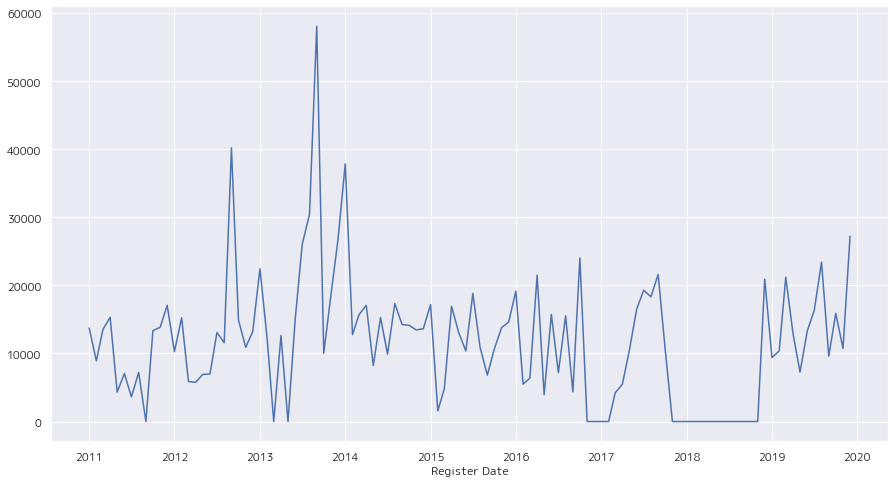

In [431]:
plt.figure(figsize=(15,8))
values = em_series.values
# plot dataset
sns.lineplot(data=em_series.resample('MS').sum())

In [432]:
em_series_month.index

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-10-01', '2011-11-01', '2011-12-01', '2012-01-01',
               '2012-02-01', '2012-03-01', '2012-04-01', '2012-05-01',
               '2012-06-01', '2012-07-01', '2012-08-01', '2012-09-01',
               '2012-10-01', '2012-11-01', '2012-12-01', '2013-01-01',
               '2013-02-01', '2013-04-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01', '2013-10-01', '2013-11-01',
               '2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01',
               '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01',
               '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01',
               '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
               '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
               '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
      

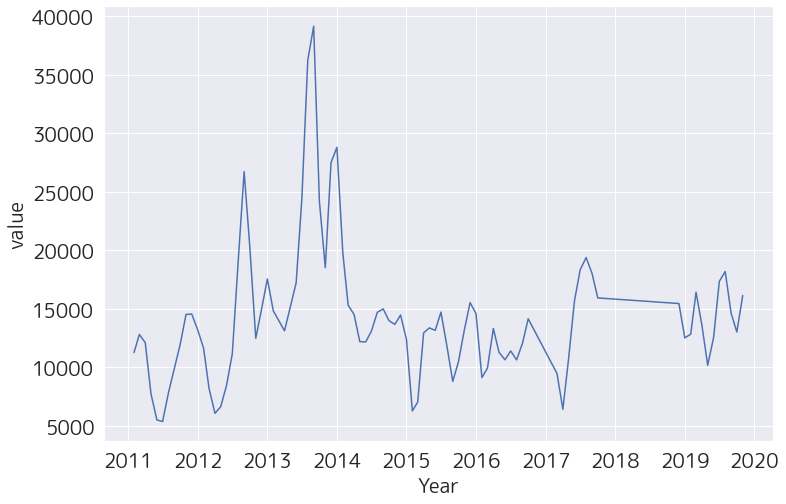

In [433]:
decomposition = seasonal_decompose(em_series_month, model='additive',period = 2)
plt.figure(figsize=(12,8))
plt.xticks(fontsize = 20, rotation = 0)
plt.yticks(fontsize = 20, rotation = 0)
plt.xlabel('Year',fontsize = 20)
plt.ylabel('value',fontsize = 20)
plt.plot(decomposition.trend)

In [434]:
def series_to_supervised(data, n_in=4, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [66]:
names = ["Gradient_Boosting", "Decision_Tree", "Extra_Trees", "Random_Forest","LGBM","XGBoost"]
models = [
    GradientBoostingRegressor(),
    DecisionTreeRegressor(max_depth=5),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    LGBMRegressor(),
    XGBRegressor()]

In [72]:
# values = pd.DataFrame(em_series.values)
# dataframe = pd.concat([values.shift(1), values], axis=1)
# dataframe.columns = ['t-1', 't']
# dataframe.dropna(inplace= True)
# target = dataframe.iloc[:,1]
# data = dataframe.iloc[:,:-1]
dataset = series_to_supervised(np.expand_dims(em_series_sample.values,axis=1), n_in=1)
data  = dataset[:,:-1]
target = dataset[:,-1]

In [73]:
# split into train and test sets
size = int(len(em_series_sample) * 0.7)
train_X, test_X = data[0:size], data[size:len(em_series_sample)]
train_y, test_y = target[0:size], target[size:len(em_series_sample)]
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
# model = XGBRegressor()
# model = LGBMRegressor()
model.fit(train_X, train_y)
yhat = model.predict(test_X)
rmse = mean_squared_error(test_y, yhat,squared=False)
mape = mean_absolute_percentage_error(test_y, yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)

Test RMSE: 1109.994
Test MAPE: 1.782


In [74]:
rmse = []
mape = []
r_squared = []
for  model in models:
    model.fit(train_X, train_y)
    y_pred  = model.predict(test_X)
#     print(y_pred)
    rmse_score = mean_squared_error(test_y, y_pred,squared=False)
    mape_score = np.mean(np.abs((test_y - y_pred)/test_y)*100)
    r_squared_score  = model.score(test_X,test_y)
    r_squared.append(r_squared_score)
    rmse.append(rmse_score)
    mape.append(mape_score)

In [75]:
df_score = pd.DataFrame()
df_score['MODELS'] = names
df_score['R_SQUARED'] = r_squared
df_score['RMSE'] = rmse
df_score['MAPE'] = mape
df_score['RMSE'] = round(df_score['RMSE'],3)
df_score['MAPE'] = round(df_score['MAPE'],3)
df_score['R_SQUARED'] = round(df_score['R_SQUARED'],3)

df_score

,MODELS,R_SQUARED,RMSE,MAPE
0,Gradient_Boosting,-0.565,846.491,170.881
1,Decision_Tree,-0.278,764.863,154.393
2,Extra_Trees,-1.300,1026.258,172.015
3,Random_Forest,-1.047,968.093,175.801
4,LGBM,-0.662,872.279,179.858
5,XGBoost,-1.560,1082.617,174.484


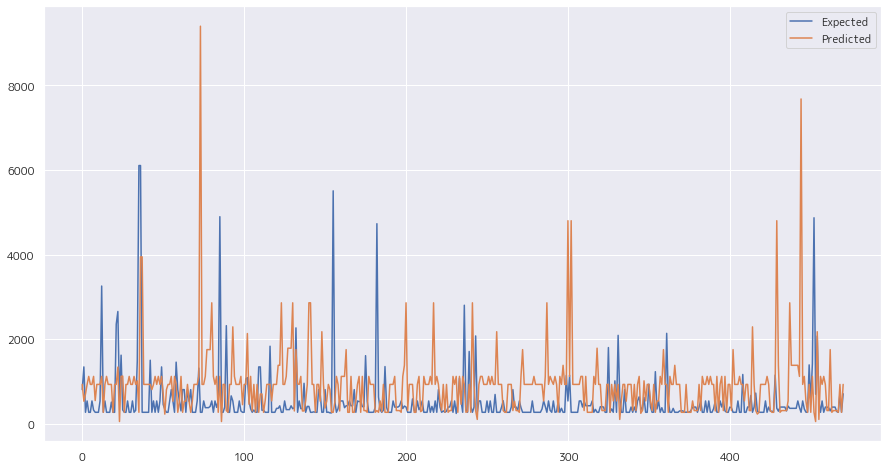

In [76]:
plt.figure(figsize=(15,8))
plt.plot(test_y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

predicted=6.321099, expected=5.592529
predicted=6.236868, expected=8.401468
predicted=6.536062, expected=6.285676
predicted=7.018450, expected=7.451050
predicted=6.778908, expected=5.592529
predicted=6.726704, expected=6.285676
predicted=6.438607, expected=5.592529
predicted=6.683464, expected=6.691141
predicted=6.231962, expected=7.096721
predicted=6.538423, expected=6.285676
predicted=6.290920, expected=5.592529
predicted=6.310192, expected=6.285676
predicted=6.136452, expected=6.978823
predicted=6.438669, expected=6.246792
predicted=6.515365, expected=7.096721
predicted=6.435535, expected=5.592529
predicted=6.295745, expected=5.592529
predicted=6.262475, expected=6.425533
predicted=6.286975, expected=5.592529
predicted=6.089310, expected=6.570883
predicted=6.209850, expected=5.592529
predicted=5.911671, expected=6.570883
predicted=5.999922, expected=5.220356
predicted=6.064981, expected=6.955428
predicted=5.985542, expected=6.726845
predicted=6.318896, expected=6.691141
predicted=6.

Test RMSE: 3169.073
Test MAPE: 0.843


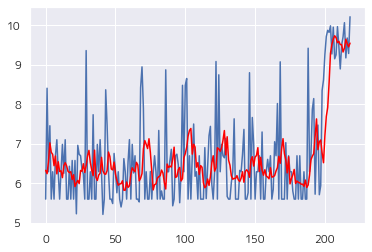

In [77]:
from statsmodels.tsa.arima.model import ARIMA

X = np.log(em_series).values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
# rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
# mape = mean_absolute_percentage_error(y_truth, y_forecasted)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


RMSE: 7484.176
MAPE: 0.460


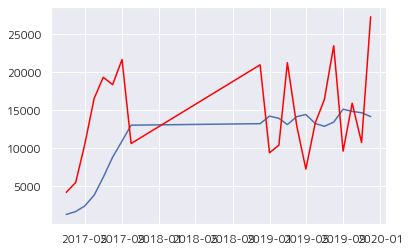

In [48]:
X = em_series.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
# predictions = list()
# # walk-forward validation
# for t in range(len(test)):
# 	model = ARIMA(history, order=(5,1,1))
# 	model_fit = model.fit()
# 	output = model_fit.forecast()
# 	yhat = output[0]
# 	predictions.append(yhat)
# 	obs = test[t]
# 	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
# # evaluate forecasts
# warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
#                         FutureWarning)
# rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
# mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
model = ARIMA(em_series, order=(1,1,1))
results = model.fit()
pred = results.predict(start='2017-01', dynamic=False)
y_forecasted = pred
y_truth = em_series['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
# plot forecasts against actual outcomes
plt.plot(y_forecasted)
plt.plot(y_truth, color='red')
plt.show()

In [49]:
plt.figure(figsize=(12,8))
# plt.plot(np.exp(predictions), color='red')
# plt.xticks(rotation = 90)
# sns.lineplot(x=list(df_sum_month['month_year'][size:len(X)]),y=np.exp(test),data=np.exp(test))
# plt.legend(loc='upper left', labels=['forecast','test'])
plt.plot(np.exp(test))
plt.plot(np.exp(predictions), color='red')
plt.show()

<ipython-input-49-ba1bbbfd531d>:6: RuntimeWarning: overflow encountered in exp
  plt.plot(np.exp(test))
D:\Software\Anaconda\lib\site-packages\matplotlib\transforms.py:379: RuntimeWarning: overflow encountered in double_scalars
  return (x0, y0, x1 - x0, y1 - y0)


IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 864x576 with 1 Axes>

In [50]:
X = np.log(em_series_sample).values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
# history = [x for x in train]
# predictions = list()
# # walk-forward validation
# for t in range(len(test)):
# 	model = ARIMA(history, order=(5,1,0))
# 	model_fit = model.fit()
# 	output = model_fit.forecast()
# 	yhat = output[0]
# 	predictions.append(yhat)
# 	obs = test[t]
# 	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
# # evaluate forecasts
# warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA')
# rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
# mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
model = ARIMA(em_series_sample, order=(4,1,1))
results = model.fit()
pred = results.predict(start='2017-01-01', dynamic=False)
y_forecasted = pred
y_truth = em_series['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
# plot forecasts against actual outcomes
plt.plot(y_forecasted)
plt.plot(y_truth, color='red')
plt.show()

# plot forecasts against actual outcomes
# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g.

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.exp(test))
plt.plot(np.exp(predictions), color='red')
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
sns.lineplot(x=list(df_sum_day['Register Date'][size:len(X)]),y=np.exp(test),data=np.exp(test))
plt.legend(loc='upper left', labels=['forecast','test'])

In [78]:
X = np.log(em_series_month).values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# model = ARIMA(np.log(em_series_month), order=(5,1,0))
# results = model.fit()
# pred = results.predict(start='2017-01', dynamic=False)
# y_forecasted = np.exp(pred)
# y_truth = em_series_month['2017-01-01':]
# rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
# mape = mean_absolute_percentage_error(y_truth, y_forecasted)
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
# # plot forecasts against actual outcomes
# plt.xticks(rotation = 90)
# plt.plot(y_forecasted,color='red')
# plt.plot(em_series_month)
# plt.show()
#walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

predicted=13648.528326, expected=3949.862360
predicted=8262.010483, expected=15739.667079
predicted=11219.243047, expected=7186.380337
predicted=9489.039525, expected=15520.000337
predicted=11143.484527, expected=4356.203933
predicted=8581.299628, expected=24033.063146
predicted=11158.980486, expected=4206.455955
predicted=9234.035952, expected=5492.182360
predicted=8391.437594, expected=10500.130337
predicted=8797.568484, expected=16521.617528
predicted=9886.834787, expected=19297.341461
predicted=11093.833029, expected=18328.933483
predicted=11931.334691, expected=21623.545506
predicted=13238.239936, expected=10606.321461
predicted=12107.217497, expected=20925.233483
predicted=13882.742069, expected=9389.784719
predicted=12422.128963, expected=10392.963146
predicted=12129.067363, expected=21203.115056
predicted=13742.560651, expected=12926.638764
predicted=13271.507343, expected=7258.704719
predicted=11703.385516, expected=13296.291124
predicted=12363.317637, expected=16341.310225
pr

In [79]:
# plt.xticks(rotation = 90)
# plt.plot_date(df_sum_month['month_year'][size:len(X)], np.exp(predictions))
# list_time_test = list(df_sum_month['month_year'][size:len(X)])
# list_time_test

df_sum_month.reset_index(inplace=True)
df_sum_month['month_year'] = df_sum_month['month_year'].astype(str)
list_datetime = list(df_sum_month['month_year'][size:len(X)])
# # list_datetime = list(df_sum_month.reset_index()['month_year'][size:len(X)])
list_datetime
# df_sum_month[df_sum_month['month_year'].map(lambda x: '2017' in x)]

['2016-05-01',
 '2016-06-01',
 '2016-07-01',
 '2016-08-01',
 '2016-09-01',
 '2016-10-01',
 '2017-03-01',
 '2017-04-01',
 '2017-05-01',
 '2017-06-01',
 '2017-07-01',
 '2017-08-01',
 '2017-09-01',
 '2017-10-01',
 '2018-12-01',
 '2019-01-01',
 '2019-02-01',
 '2019-03-01',
 '2019-04-01',
 '2019-05-01',
 '2019-06-01',
 '2019-07-01',
 '2019-08-01',
 '2019-09-01',
 '2019-10-01',
 '2019-11-01',
 '2019-12-01']

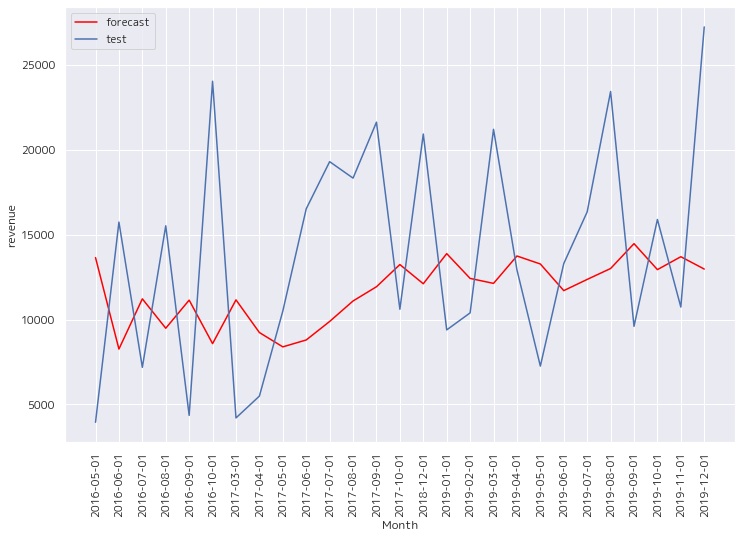

In [80]:
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
plt.xlabel('Month')
plt.ylabel('revenue')
sns.lineplot(x=list_datetime,y='total_price',data=df_sum_month[size:len(X)])
plt.legend(loc='upper left', labels=['forecast','test'])

# plt.figure(figsize=(12,8))
# plt.plot(np.exp(predictions), color='red')
# plt.plot(em_series_month)
# plt.xticks(rotation = 90)
# plt.ylabel('revenue')
# # sns.lineplot(x=list(df_sum_year['year']),y='total_price_1g',data=df_sum_year)
# plt.legend(loc='best', labels=['forecast','test'])

In [82]:
X = em_series_month.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# model = ARIMA(np.log(em_series_month), order=(5,1,0))
# results = model.fit()
# pred = results.predict(start='2017-01', dynamic=False)
# y_forecasted = np.exp(pred)
# y_truth = em_series_month['2017-01-01':]
# rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
# mape = mean_absolute_percentage_error(y_truth, y_forecasted)
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
# # plot forecasts against actual outcomes
# plt.xticks(rotation = 90)
# plt.plot(y_forecasted,color='red')
# plt.plot(em_series_month)
# plt.show()
#walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
rmse = mean_squared_error(test, predictions,squared=False)
mape =mean_absolute_percentage_error(test, predictions)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

predicted=15541.202733, expected=3949.862360
predicted=8850.900607, expected=15739.667079
predicted=12349.046394, expected=7186.380337
predicted=13006.004908, expected=15520.000337
predicted=9992.904382, expected=4356.203933
predicted=11990.069378, expected=24033.063146
predicted=11933.183662, expected=4206.455955
predicted=13311.367910, expected=5492.182360
predicted=7425.366875, expected=10500.130337
predicted=13708.573163, expected=16521.617528
predicted=9207.117045, expected=19297.341461
predicted=13348.686125, expected=18328.933483
predicted=14126.845322, expected=21623.545506
predicted=15762.363897, expected=10606.321461
predicted=13975.475553, expected=20925.233483
predicted=15326.124799, expected=9389.784719
predicted=15452.864229, expected=10392.963146
predicted=11907.948816, expected=21203.115056
predicted=17450.379880, expected=12926.638764
predicted=13956.257962, expected=7258.704719
predicted=13085.272863, expected=13296.291124
predicted=14794.325443, expected=16341.310225

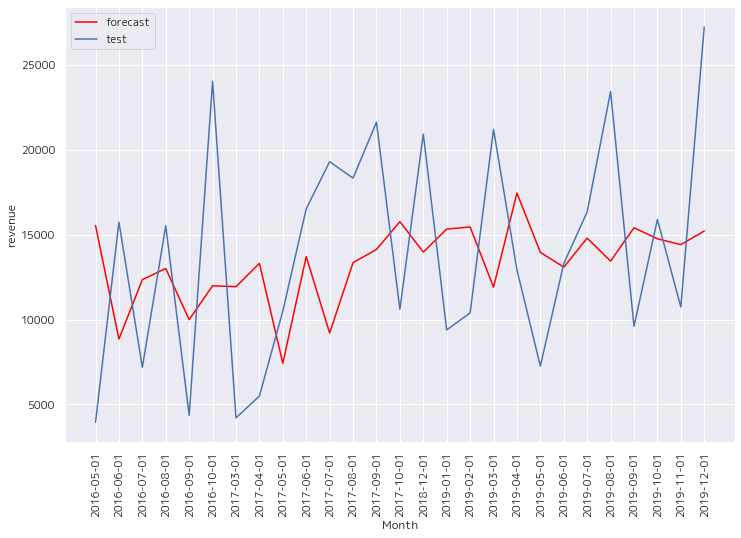

In [83]:
plt.figure(figsize=(12,8))
plt.plot(predictions, color='red')
plt.xticks(rotation = 90)
plt.xlabel('Month')
plt.ylabel('revenue')
sns.lineplot(x=list_datetime,y='total_price',data=df_sum_month[size:len(X)])
plt.legend(loc='upper left', labels=['forecast','test'])


RMSE: 100627.264
MAPE: 1.848


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


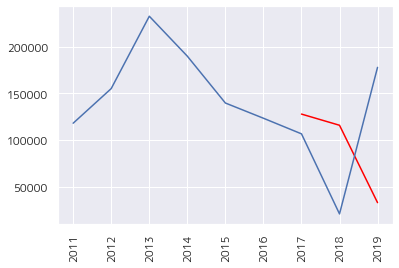

In [84]:
# X = np.log(em_series_year).values
X = em_series_year.values
# size = int(len(X) * 0.5)
# train, test = X[0:size], X[size:len(X)]
# history = [x for x in train]
model = ARIMA(em_series_year, order=(3,1,0))
results = model.fit()
pred = results.predict(start='2017-01-01', dynamic=False)
y_forecasted = pred
y_truth = em_series_year['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
# plot forecasts against actual outcomes
plt.xticks(rotation = 90)
plt.plot(y_forecasted,color='red')
plt.plot(em_series_year)
plt.show()
# predictions = list()|
# # walk-forward validation
# for t in range(len(test)):
# 	model = ARIMA(history, order=(1,1,0))
# 	model_fit = model.fit()
# 	output = model_fit.forecast()
# 	yhat = output[0]
# 	predictions.append(yhat)
# 	obs = test[t]
# 	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
# # evaluate forecasts
# rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
# mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
# # plot forecasts against actual outcomes
# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

In [57]:
# df_sum_year.reset_index(inplace=True)
# df_sum_year['year'] = df_sum_year['year'].astype(str)
list_datetime = list(df_sum_year['year'][size:len(X)])
# # list_datetime = list(df_sum_month.reset_index()['month_year'][size:len(X)])
# list_datetime
list(df_sum_year['year'][6:])

[Timestamp('2017-01-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2019-01-01 00:00:00')]

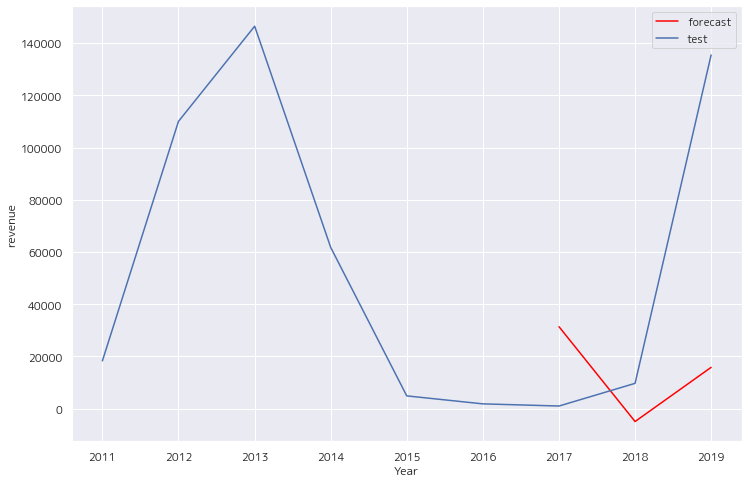

In [58]:
plt.figure(figsize=(12,8))
plt.plot(y_forecasted, color='red')
plt.plot(em_series_year)
# plt.xticks(rotation = 90)
plt.xlabel('Year')
plt.ylabel('revenue')
# sns.lineplot(x=list(df_sum_year['year']),y='total_price_1g',data=df_sum_year)
plt.legend(loc='best', labels=['forecast','test'])

In [64]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [65]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
            mod = SARIMAX(em_series_month,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1463.6826159443951
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1204.5665866040997
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1214.4718158668404
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:942.7019066092066
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1225.770062887054
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1209.013168612887
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:974.394368553723
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:942.170277539414
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1422.2024411190644
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1168.8233582244577
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1182.3281422350267
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:918.6641565449515
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1212.7405049395716
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1170.683285739297
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:967.9574382854047


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:918.7907098517547
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1419.3461621471213
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1170.503630246791
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:1191.6896716163335
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:927.0471101077379
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:1193.3076606905843


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1172.1886584500191
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:953.9944086362788
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:918.7911064886256
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1383.9631372137599
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1137.226785642893
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:1158.3844155588304
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:889.786726145087
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:1181.3621424351122


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1137.6310400607867
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:943.5192294035334
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:888.1284273528518
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1428.4249184268658
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1181.6400167191728
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:1199.7540495509597
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:933.9077695127295


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:1183.2740775067994
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1183.4074195233843
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:943.1847751073108
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:932.3341419509717
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1404.6334589951614


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1157.1584490148946
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:1177.3693043491419
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:910.890155167245
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:1181.388311367782
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1158.2618626445337


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:942.320386283855
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:909.438673753262
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1415.3391395325814
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1165.9266764084628
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:1186.78529146844
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:917.4563134126075


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:1167.9343548425688
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1167.42877972477
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:927.1978734822403
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:914.0851721731258


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1382.1039150977754
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1137.7831157952608
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:1159.4125764819387
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:891.2825474025117
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:1159.5711727414007


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1137.4494653853137
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:924.0044350602751
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:889.4245395460883


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [435]:
mod =SARIMAX(em_series_month,
#                                 order=(5, 0, 0),
#                                 seasonal_order=(0, 1, 0, 2),
                                             order=(5, 0, 0),
                                seasonal_order=(5, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4535      1.263      0.359      0.719      -2.021       2.928
ar.L2          0.5120      1.337      0.383      0.702      -2.108       3.132
ar.L3         -0.9354      1.339     -0.699      0.485      -3.560       1.689
ar.L4          0.5937      1.314      0.452      0.651      -1.981       3.169
ar.L5          0.4118      1.338      0.308      0.758      -2.210       3.034
ar.S.L12      -0.0237      1.357     -0.017      0.986      -2.682       2.635
ar.S.L24       0.4029      0.867      0.465      0.642      -1.296       2.101
ar.S.L36      -0.3763      0.540     -0.697      0.486      -1.435       0.682
ar.S.L48      -0.3408      0.525     -0.649      0.516      -1.370       0.689
ar.S.L60      -0.2180      0.692     -0.315      0.753      -1.575       1.139
sigma2      7.387e+07   7.16e-09   1.03e+16      0.0

In [436]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1152x576 with 0 Axes>

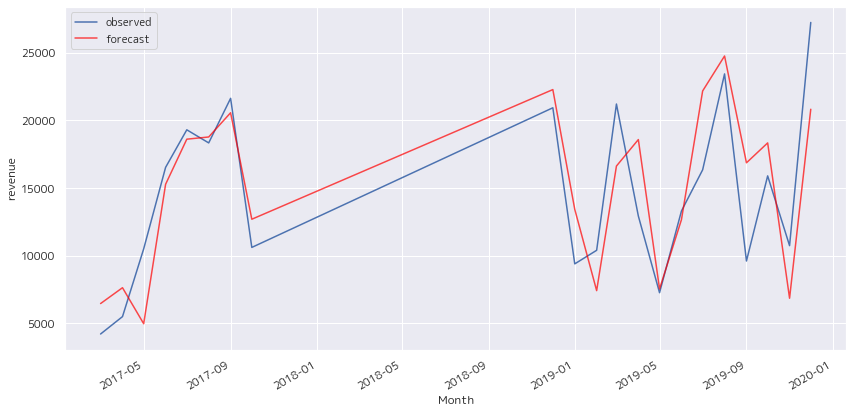

In [437]:
pred = results.get_prediction(start='2017-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_month['2017-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [204]:
# pred = results.get_prediction(start='2019-01', dynamic=False)
# pred_ci = pred.conf_int()

# ax = em_series_month['2019-01':].plot(label='observed')
# pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# # ax.fill_between(pred_ci.index,
# #                 pred_ci.iloc[:, 0],
# #                 pred_ci.iloc[:, 1], color='k', alpha=.2)

# ax.set_xlabel('Month')
# ax.set_ylabel('revenue')
# plt.legend()

# plt.show()

In [438]:
y_forecasted = pred.predicted_mean
y_truth = em_series_month['2017-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 3644.371
MAPE: 0.251


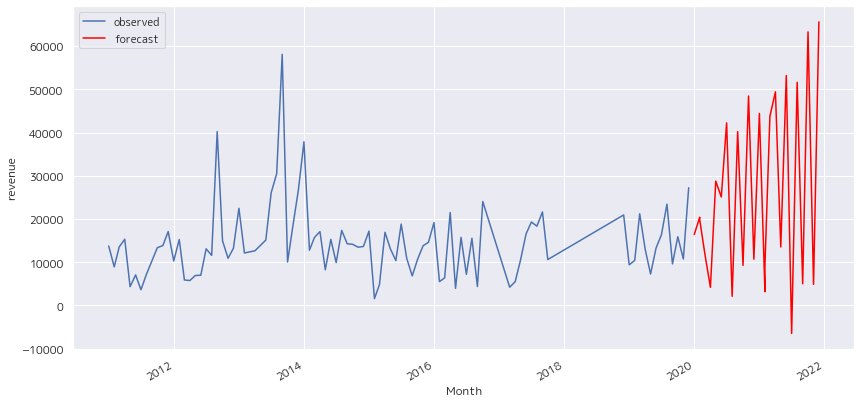

In [439]:
index = pd.to_datetime(['2020-01-01', '2020-02-01','2020-03-01','2020-02-01','2020-04-01','2020-05-01',
                        '2020-06-01','2020-07-01','2020-08-01','2020-09-01','2020-10-01','2020-11-01','2020-12-01',
                       '2021-01-01', '2021-02-01','2021-03-01','2021-02-01','2021-04-01','2021-05-01',
                        '2021-06-01','2021-07-01','2021-08-01','2021-09-01','2021-10-01','2021-11-01','2021-12-01'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_month.plot(label='observed', figsize=(14, 7),)
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [440]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2020-01-01,16379.269425
2020-02-01,20391.618568
2020-03-01,11880.661043
2020-02-01,19801.513796
2020-04-01,4168.690703
2020-05-01,28743.337590
2020-06-01,25092.069369
2020-07-01,42228.687583
2020-08-01,2104.687462
2020-09-01,40216.203174


In [441]:
mod =SARIMAX(em_series_year,
#                                 order=(0, 0, 1),
#                                 seasonal_order=(0, 0, 0, 12),
                                order=(1, 0, 0),
                                seasonal_order=(1, 0, 1, 2),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

# mod =SARIMAX(em_series_year,
#                                 order=(0, 0, 0),
#                                 seasonal_order=(0, 0, 0, 12),
#                                 enforce_stationarity=False,
#                                 enforce_invertibility=False)

# results = mod.fit()

# print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7846      0.916      1.949      0.051      -0.010       3.579
ar.S.L2       -0.0064      0.501     -0.013      0.990      -0.989       0.976
ma.S.L2        3.6429      4.506      0.808      0.419      -5.188      12.474
sigma2      5.394e+09   1.08e-10   4.97e+19      0.000    5.39e+09    5.39e+09


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


In [442]:
em_series_month

month_year
2011-01-01    13744.770000
2011-02-01     8914.273596
2011-03-01    13524.721573
2011-04-01    15311.764382
2011-05-01     4320.827191
                  ...     
2019-08-01    23429.103034
2019-09-01     9601.233933
2019-10-01    15892.667865
2019-11-01    10736.095506
2019-12-01    27231.691124
Length: 88, dtype: float64

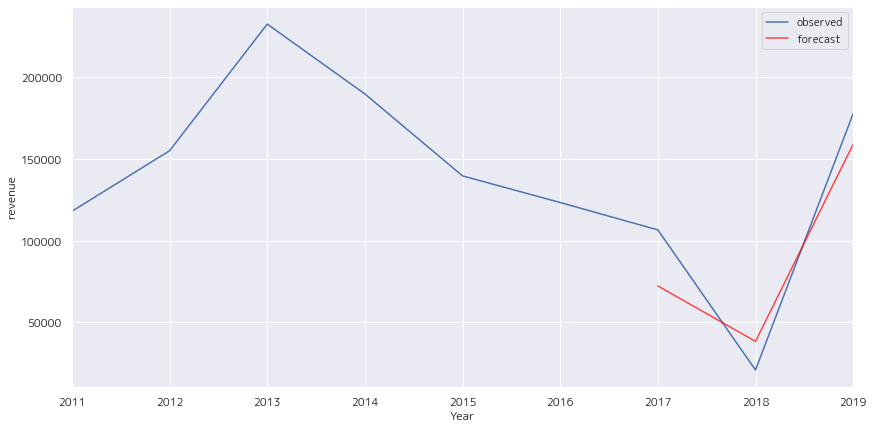

In [443]:
pred = results.get_prediction(start='2017-01-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_year['2011-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', alpha=.7, figsize=(14, 7),color='red')

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [444]:
y_forecasted = pred.predicted_mean
y_truth = em_series_year['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
# mape = mean_absolute_percentage_error(y_forecasted,y_truth)

print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 24711.279
MAPE: 0.421


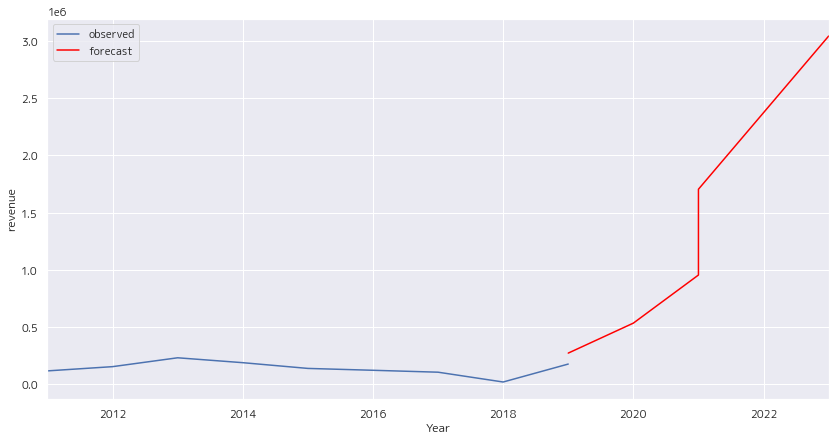

In [445]:
index = pd.to_datetime(['2019', '2020','2021','2021','2023'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_year.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [279]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2019-01-01,134761.234903
2020-01-01,0.000000
2021-01-01,0.000000
2021-01-01,0.000000
2023-01-01,0.000000


In [85]:
df_1nz  = df_copy[df_copy["extracted_engine"].apply(lambda x : '4G63' in x)]
df_1nz

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em
24129,924,2011-01-31,8407343009,"ДВИГАТЕЛЬ ДЛЯ А/М MITSUBISHI LANCER EVOLUTION,...",MITSUBISHI MOTOR CO.,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","AKSYS CORPORATION CO., LTD.",...,CFR,150.00,147.00,222.00,[4G63],MITSUBISHI,2011-01,2011,1,1
24143,1681,2011-02-09,8407343009,"ДВИГАТЕЛЬ ВНУТР. СГОРАНИЯ ДЛЯ Л/АВТОМОБИЛЯ, С ...","MITSUBISHI MOTOR CO., MITSUBISHI",MITSUBISHI,П-КАМЧАТСКИЙ,"JP, JPN, Japan","CT, , Taiwan","DRUZHBA CO., LTD.",...,CFR,613.80,613.80,693.00,"[4G64, 4G63]",MITSUBISHI,2011-02,2011,2,2
24148,1909,2011-02-11,8407343009,"ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЕНЗИНОВЫЕ, Б/У...","TOYOTA, NISSAN, HONDA, MITSUBISHI",TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","CT, , Taiwan","KAIHO SANGYO CO.,LTD.",...,CFR,1903.85,1903.85,1473.08,[4G63],MITSUBISHI,2011-02,2011,1,1
24149,1951,2011-02-14,8407343009,ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЫВШИЕ В УПОТРЕ...,"TOYOTA MOTOR CORPORATION,HONDA MOTOR CO.,LTD,M...","TOYOTA,MITSUBISHI,HONDA,SUBARU,NISSAN,DAIHATSU",CFR ВОСТОЧНЫЙ,"JP, JPN, Japan","CT, , Taiwan","HIKARI SYOJI CO.,LTD 27 YAWATAKUBOTA YAWATA-CI...",...,CFR,4630.00,4630.00,4230.00,"[4G63, 4G63]",MITSUBISHI,2011-02,2011,1,2
24158,2664,2011-02-21,8407343009,"ДВИГАТЕЛЬ (БЕНЗИН), ДЛЯ ЛЕГКОВОГО А/М, MITSUBI...","MITSUBISHI, MMC",MMC,МАГАДАН,"JP, JPN, Japan","CT, , Taiwan","ISHIDA MOTORS CO., LTD",...,CFR,200.00,200.00,100.00,[4G63],MITSUBISHI,2011-02,2011,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30230,257442,2019-12-01,8407343009,"ДВИГАТЕЛИ ВНУТРЕН, СГОРАНИЯ С ИСКР. ЗАЖИГ, БЕН...",MITSUBISHI,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",BSI LLC,...,CFR,2016.00,2016.00,3044.21,[4G63],MITSUBISHI,2019-12,2019,1,1
30231,257443,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ В СБОРЕ С КПП ДЛЯ ЛЕГКОВО...,MITSUBISHI MOTORS CORPORATION,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",JAPAN TREK CO. LTD.,...,CFR,764.57,640.00,966.40,"[4G63, 4G63]",MITSUBISHI,2019-12,2019,1,2
30240,257511,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ В СБОРЕ С КПП ДЛЯ ЛЕГКОВО...,MITSUBISHI MOTORS CORPORATION,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",JAPAN TREK CO. LTD.,...,CFR,276.69,230.00,347.30,[4G63],MITSUBISHI,2019-12,2019,1,1
30249,257800,2019-12-01,8407343009,"ЗАПАСНЫЕ ЧАСТИ ДЛЯ А/М, Б/У. ДВИГАТЕЛИ ВНУТРЕН...",MITSUBISHI,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",HOKUSHO CORPORATION LTD,...,CFR,980.00,980.00,1488.61,"[4G93, 4G93, 4G63]",MITSUBISHI,2019-12,2019,2,3


In [86]:
df_1nz['count_em']  = df_1nz['extracted_engine'].map(lambda x: count_length(x,'4G63'))
unit_price_1nz = df_1nz[(df_1nz.Quantity == 1) & (df_1nz.count_em==1)].describe().loc[('mean','Cargo Value USD')]
df_1nz['Quantity'] = df_1nz.apply(lambda x : normalize_zero (x,unit_price_1nz), axis=1)
df_1nz['total_price'] = df_1nz.apply(lambda x : check_count_em(x,unit_price_1nz),axis=1)

<ipython-input-86-548083c4fe0e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1nz['count_em']  = df_1nz['extracted_engine'].map(lambda x: count_length(x,'4G63'))
<ipython-input-86-548083c4fe0e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1nz['Quantity'] = df_1nz.apply(lambda x : normalize_zero (x,unit_price_1nz), axis=1)
<ipython-input-86-548083c4fe0e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [87]:
df_1g  = df_copy[df_copy["extracted_engine"].apply(lambda x : '4G64' in x)]
df_1g

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em
24135,1239,2011-02-01,8407343009,ДВИГАТЕЛЬ А/М Б/У БЕНЗИН С ОБЪЕМОМ БОЛЕЕ 1000С...,"MITSUBISHI,TOYOTA,MAZDA,HONDA","MITSUBISHI,TOYOTA,MAZDA,HONDA",ВЛАДИВОСТОК,"JP, JPN, Japan","CT, , Taiwan",PIONEER COMPANY LTD.,...,CFR,5730.0,5730.0,3617.32,"[4G64, 4G93]",MITSUBISHI,2011-02,2011,2,2
24143,1681,2011-02-09,8407343009,"ДВИГАТЕЛЬ ВНУТР. СГОРАНИЯ ДЛЯ Л/АВТОМОБИЛЯ, С ...","MITSUBISHI MOTOR CO., MITSUBISHI",MITSUBISHI,П-КАМЧАТСКИЙ,"JP, JPN, Japan","CT, , Taiwan","DRUZHBA CO., LTD.",...,CFR,613.8,613.8,693.00,"[4G64, 4G63]",MITSUBISHI,2011-02,2011,2,2
24160,2691,2011-02-28,8407343009,ДВИГАТЕЛИ БЕНЗ.БЫВ.В УП.В СБОРЕ С НАВЕСНЫМ ОБО...,"TOYOTA MOTOR CORPORATION,HONDA MOTOR CO.,LTD,N...","TOYOTA,HONDA,NISSAN,SUZUKI,MMC",ВОСТОЧНЫЙ,"JP, JPN, Japan","CT, , Taiwan","JEEP SIB CO.,LTD",...,CFR,6970.0,6970.0,3400.00,"[4G64, 4G63]",MITSUBISHI,2011-02,2011,2,2
24176,2885,2011-03-14,8407343009,ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЫВШИЕ В УПОТРЕ...,"HONDA MOTOR CO.,LTD,MITSUBISHI MOTORS CORPORAT...","HONDA,MITSUBISHI,MAZDA,SUBARU",CFR ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan","ROYAL AUTO PARTS CO.,LTD 724-141 OKIHARU BESHI...",...,CFR,9029.4,9029.4,8934.67,"[4G64, 4G64, 4G64, 4G15, 4G63]",MITSUBISHI,2011-03,2011,3,5
24177,2890,2011-03-14,8407343009,ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЫВШИЕ В УПОТРЕ...,"HONDA MOTOR CO.,LTD,MITSUBISHI MOTORS CORPORAT...","HONDA,MITSUBISHI,MAZDA,SUBARU",CFR ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",HEIWA SYOUJI KABUSHIKIGAISHA 10-8 MINAMIFUTAJI...,...,CFR,7068.6,7068.6,6962.42,"[4G13, 4G64]",MITSUBISHI,2011-03,2011,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30243,257586,2019-12-01,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ БЫВШИЕ В УПОТРЕБЛЕНИИ СТА...,MITSUBISHI MOTOR CO,MITSUBISHI,ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",KUSAYAMA PARTS CO. LTD,...,CFR,2450.0,2450.0,3765.79,"[4G64, 4G15]",MITSUBISHI,2019-12,2019,2,2
30244,257683,2019-12-01,8407343009,"ЗАП.ЧАСТИ ДЛЯ АВТОМОБИЛЕЙ, Б/У: ДВИГАТЕЛИ БЫВШ...",MITSUBISHI,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",IWAMA WORKS CO. LTD,...,CFR,260.0,260.0,393.06,[4G64],MITSUBISHI,2019-12,2019,1,1
30251,257880,2019-12-01,8407343009,"ЗАПАСНЫЕ ЧАСТИ ДЛЯ А/М, Б/У, ДВИГАТЕЛИ ВНУТРЕН...",MITSUBISHI,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",MARUKO SHOJI CO. LTD.,...,CFR,960.0,960.0,1449.60,"[4G64, 4G93]",MITSUBISHI,2019-12,2019,2,2
30255,257959,2019-12-01,8407343009,"ЗАП.ЧАСТИ ДЛЯ АВТОМОБИЛЕЙ, Б/У: ДВИГАТЕЛИ БЫВШ...",MITSUBISHI,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",KAWASHIMA CO.LTD,...,CFR,240.0,240.0,361.99,[4G64],MITSUBISHI,2019-12,2019,1,1


In [88]:
df_1g['count_em']  = df_1g['extracted_engine'].map(lambda x: count_length(x,'4G64'))
unit_price_1g = df_1g[(df_1g.Quantity == 1) & (df_1g.count_em==1)].describe().loc[('mean','Cargo Value USD')]
df_1g['Quantity'] = df_1g.apply(lambda x : normalize_zero (x,unit_price_1g), axis=1)
df_1g['total_price'] = df_1g.apply(lambda x : check_count_em(x,unit_price_1g),axis=1)

<ipython-input-88-82266b56f109>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1g['count_em']  = df_1g['extracted_engine'].map(lambda x: count_length(x,'4G64'))
<ipython-input-88-82266b56f109>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1g['Quantity'] = df_1g.apply(lambda x : normalize_zero (x,unit_price_1g), axis=1)
<ipython-input-88-82266b56f109>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [89]:
df_fp  = df_copy[df_copy["extracted_engine"].apply(lambda x : '4G15' in x)]
df_fp

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em
24127,91,2011-01-21,8407343009,"ЗАП.ЧАСТИ ДЛЯ А/М, Б/У ДВИГАТЕЛЯ С АКП ЯПОНСКО...","TOYOTA,MITSUBISHI,SUBARU","TOYOTA,MITSUBISHI,SUBARU",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","АВТОЛОМ ДЖАПАН КО.,ЛТД",...,CFR,600.0,600.0,480.00,[4G15],MITSUBISHI,2011-01,2011,1,1
24131,974,2011-01-18,8407343009,"ДВИГАТЕЛИ БЕНЗИН.-21ШТ.,БЫВ.В УПОТРЕБЛ.ДЛЯ ЛЕК...","HONDA MOTOR COMPANY,TOYOTA MOTOR CORPORATION,S...","HONDA,TOYOTA,SUBARU,MITSUBISHI,NISSAN,MAZDA",ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan","YAMADA MOTOR CO.,LTD.16-6,SHIMIZU-KU NISHITAKA...",...,CFR,4594.0,4594.0,6891.00,"[4G15, 6G74]",MITSUBISHI,2011-01,2011,2,2
24144,1698,2011-02-08,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ Б/У ОТ А/М В СБОРЕ С АКП:...,MITSUBISHI,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","CT, , Taiwan",WAKE CORPORATION LTD,...,CFR,2079.0,2079.0,752.40,"[4G13, 6A13, 6A13, 4G15]",MITSUBISHI,2011-02,2011,3,4
24155,2636,2011-02-24,8407343009,"ДВИГАТЕЛИ БЕНЗИНОВЫЕ С ОБЪЁМОМ БОЛЕЕ 1000СМ3, ...","HONDA, TOYOTA, MITSUBISHI, NISSAN",HONDA,ВЛАДИВОСТОК,"JP, JPN, Japan","CT, , Taiwan","FESCO LINES VLADIVOSTOK,LLC, 34POSYETSKAYA STR...",...,CFR,2280.0,2280.0,1080.00,[4G15],MITSUBISHI,2011-02,2011,1,1
24161,2695,2011-02-28,8407343009,ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЫВШИЕ В УПОТРЕ...,"MITSUBISHI MOTORS CORPORATION, MITSUBISHI",MITSUBISHI,CFR ВОСТОЧНЫЙ,"JP, JPN, Japan","CT, , Taiwan","ROYAL AUTO PARTS CO.,LTD 724-141 OKIHARU BESHI...",...,unknown,7480.0,7480.0,7534.52,"[4G15, 4G15, 4G15, 4G15, 4G15]",MITSUBISHI,2011-02,2011,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30259,258189,2019-12-01,8407343009,ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЫВШИЕ В УПОТРЕ...,FUJI HEAVY INDUSTRIES CO.LTDMITSUBISHI MOTORS ...,SUBARUMITSUBISHI,ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",WEST-JAPAN AUTO RECYCLE CO.LTD (WARC),...,CFR,1229.0,1229.0,1866.49,"[4B11, 4G15, 6G74]",MITSUBISHI,2019-12,2019,3,3
30264,258373,2019-12-01,8407343009,"ДВИГАТЕЛЬ АВТОМОБИЛЬНЫЙ БЫВШИЙ В УПОТРЕБЛЕНИИ,...",MITSUBISHI MOTORS CORPORATION,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","HK, HKG, Hong Kong",TRUTH LOGISTICS CORPORATION,...,CFR,570.0,570.0,855.06,"[4A91, 4A91, 4G15]",MITSUBISHI,2019-12,2019,2,3
30266,258418,2019-12-01,8407343009,"ЗАП.ЧАСТИ ДЛЯ АВТОМОБИЛЕЙ, Б/У: ДВИГАТЕЛИ БЫВШ...",MITSUBISHI,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",ROOTS CO. LTD,...,CFR,210.0,210.0,316.36,[4G15],MITSUBISHI,2019-12,2019,1,1
30267,258419,2019-12-01,8407343009,"ЗАП.ЧАСТИ ДЛЯ АВТОМОБИЛЕЙ, Б/У: ДВИГАТЕЛИ БЫВШ...",MITSUBISHI,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",ROOTS CO. LTD,...,CFR,210.0,210.0,316.36,[4G15],MITSUBISHI,2019-12,2019,1,1


In [90]:
df_fp['count_em']  = df_fp['extracted_engine'].map(lambda x: count_length(x,'4G15'))
unit_price_1g = df_fp[(df_fp.Quantity == 1) & (df_fp.count_em==1)].describe().loc[('mean','Cargo Value USD')]
df_fp['Quantity'] = df_fp.apply(lambda x : normalize_zero (x,unit_price_1g), axis=1)
df_fp['total_price'] = df_fp.apply(lambda x : check_count_em(x,unit_price_1g),axis=1)

<ipython-input-90-fb350493c28a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fp['count_em']  = df_fp['extracted_engine'].map(lambda x: count_length(x,'4G15'))
<ipython-input-90-fb350493c28a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fp['Quantity'] = df_fp.apply(lambda x : normalize_zero (x,unit_price_1g), axis=1)
<ipython-input-90-fb350493c28a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [91]:
df_3s['name_em'] = '4G93'
df_1nz['name_em'] = '4G63'
df_1g['name_em'] = '4G64'
df_fp['name_em'] = '4G15'

<ipython-input-91-d8c636bd845b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3s['name_em'] = '4G93'
<ipython-input-91-d8c636bd845b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1nz['name_em'] = '4G63'
<ipython-input-91-d8c636bd845b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

In [92]:
df_best_engine  = pd.concat([df_3s,df_1nz,df_1g,df_fp],axis=0)

In [93]:
df_group_year = df_best_engine.groupby(['year','name_em'])['total_price'].sum().reset_index()
df_group_year

,year,name_em,total_price
0,2011,4G15,35256.542553
1,2011,4G63,74230.982283
2,2011,4G64,56267.897143
3,2011,4G93,117968.858539
4,2012,4G15,62625.141702
5,2012,4G63,63897.163043
6,2012,4G64,80740.830357
7,2012,4G93,154982.425618
8,2013,4G15,196176.495745
9,2013,4G63,145247.560543


Text(0.5, 0, 'Year')

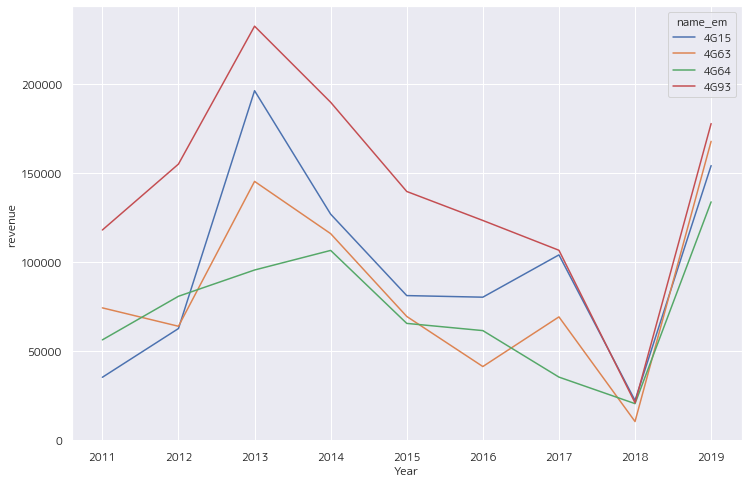

In [94]:
plt.figure(figsize=(12,8))
sns.lineplot(x='year',y='total_price',hue='name_em',data=df_group_year)
plt.ylabel('revenue')
plt.xlabel('Year')

In [95]:
df_group_month = df_best_engine.groupby(['month_year','name_em'])['total_price'].sum().reset_index()
df_group_month

,month_year,name_em,total_price
0,2011-01,4G15,704.229787
1,2011-01,4G63,222.000000
2,2011-01,4G93,13744.770000
3,2011-02,4G15,2425.378723
4,2011-02,4G63,6303.223043
...,...,...,...
345,2019-11,4G93,10736.095506
346,2019-12,4G15,11039.377660
347,2019-12,4G63,14603.257935
348,2019-12,4G64,13206.242143


Text(0.5, 0, 'Month')

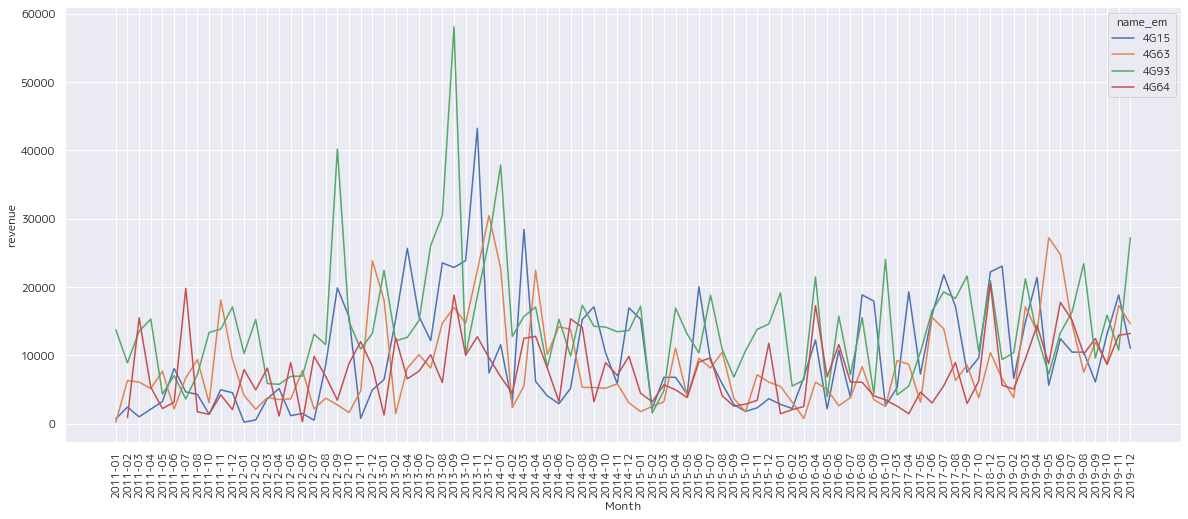

In [96]:
plt.figure(figsize=(20,8))
sns.lineplot(x='month_year',y='total_price',hue='name_em',data=df_group_month)
plt.xticks(rotation = 90)
plt.ylabel('revenue')
plt.xlabel('Month')

Text(0.5, 0, 'Month')

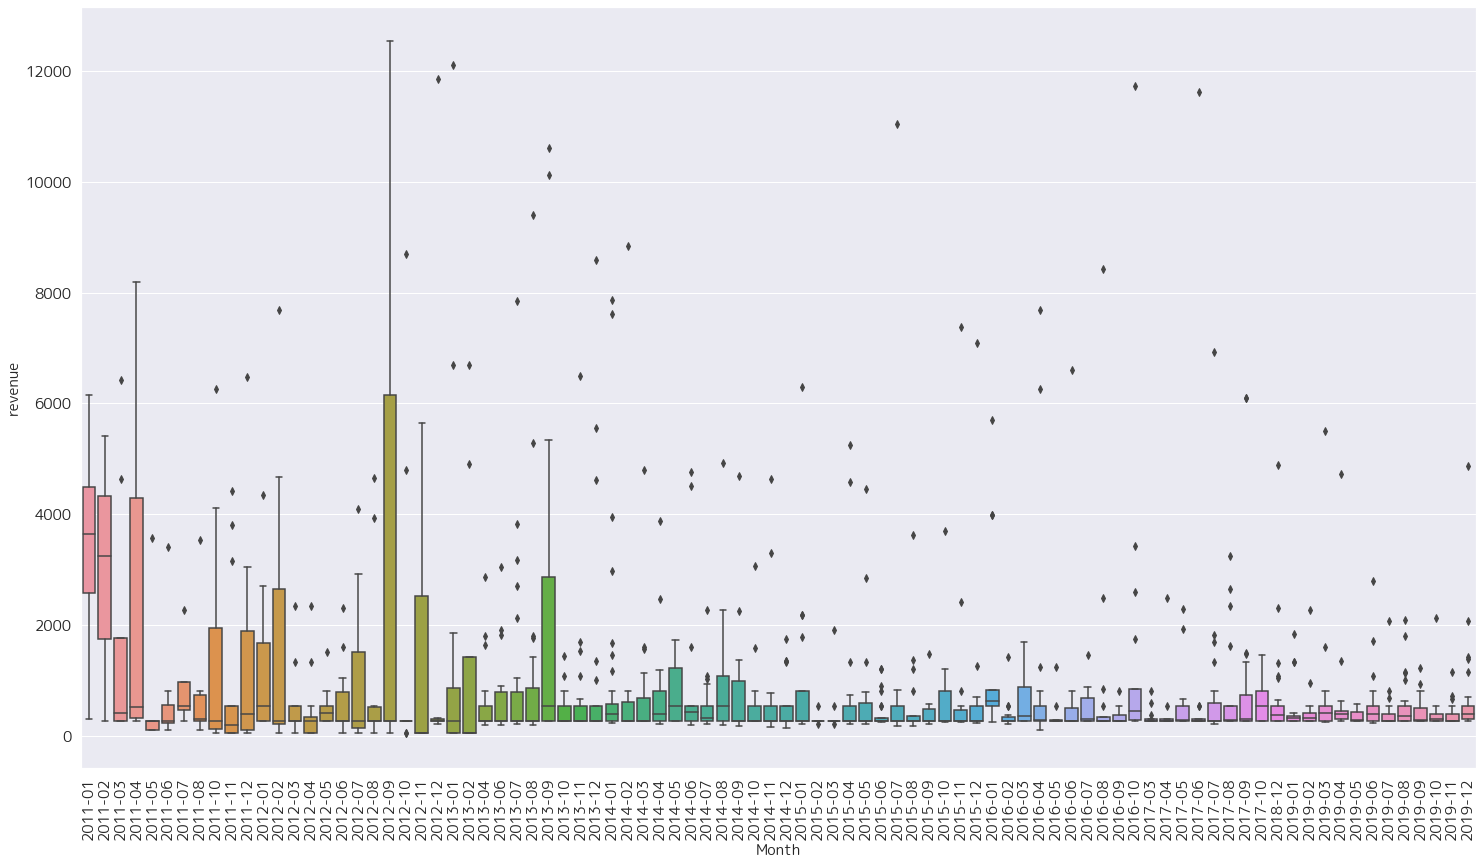

In [97]:
plt.figure(figsize=(25,14))
sns.boxplot(x='month_year',y='total_price',data=df_3s)
# plt.xticks(rotation = 90)
plt.xticks(fontsize = 15,rotation = 90, weight='bold')
plt.yticks(fontsize = 15)
plt.ylabel('revenue',fontsize = 15)
plt.xlabel('Month',fontsize = 15)

Text(0.5, 0, 'Year')

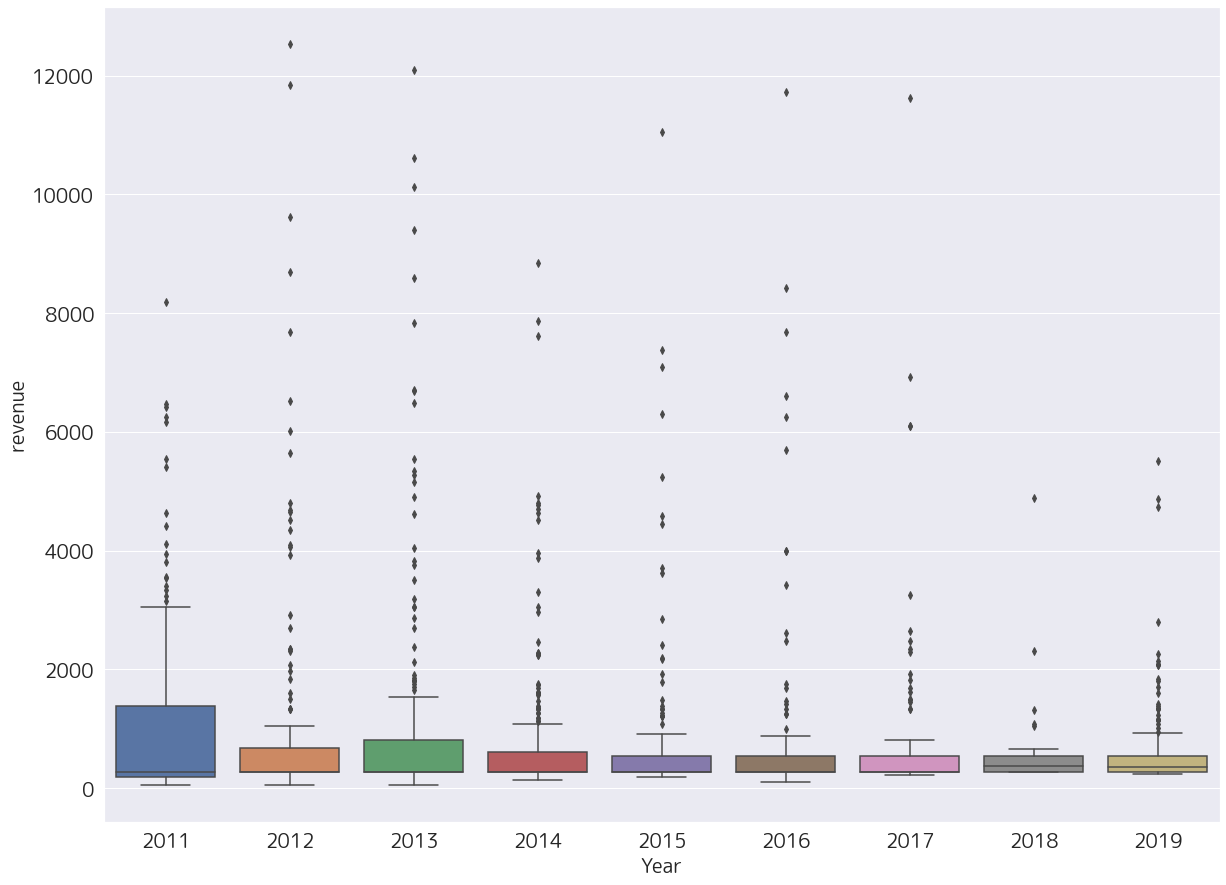

In [98]:
plt.figure(figsize=(20,15))
sns.boxplot(x='year',y='total_price',data=df_3s)
# plt.xticks(rotation = 90)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('revenue',fontsize = 20)
plt.xlabel('Year',fontsize = 20)

# Engine Model 4G63

In [99]:
df_sum_day = df_1nz.groupby(['Register Date'])['total_price'].sum().reset_index()
df_sum_month = df_1nz.groupby(['month_year'])['total_price'].sum().reset_index()
df_sum_year = df_1nz.groupby(['year'])['total_price'].sum().reset_index()
df_sum_month['month_year'] = pd.to_datetime(df_sum_month['month_year'],format='%Y-%m')
df_sum_month.set_index('month_year',inplace = True)
# df_sum_day['Register Date'] = df_sum_day['Register Date'].astype(str)
df_sum_year['year'] = pd.to_datetime(df_sum_year['year'],format='%Y')
em_series_month =  pd.Series(df_sum_month.total_price.values,index=df_sum_month.index)
em_series_year =  pd.Series(df_sum_year.total_price.values,index=df_sum_year['year'])
em_series = pd.Series(df_sum_day.total_price.values,index=df_sum_day['Register Date'])
em_series_sample = pd.Series(df_1nz.total_price.values,index=df_1nz['Register Date'])

Text(0.5, 0, 'Month')

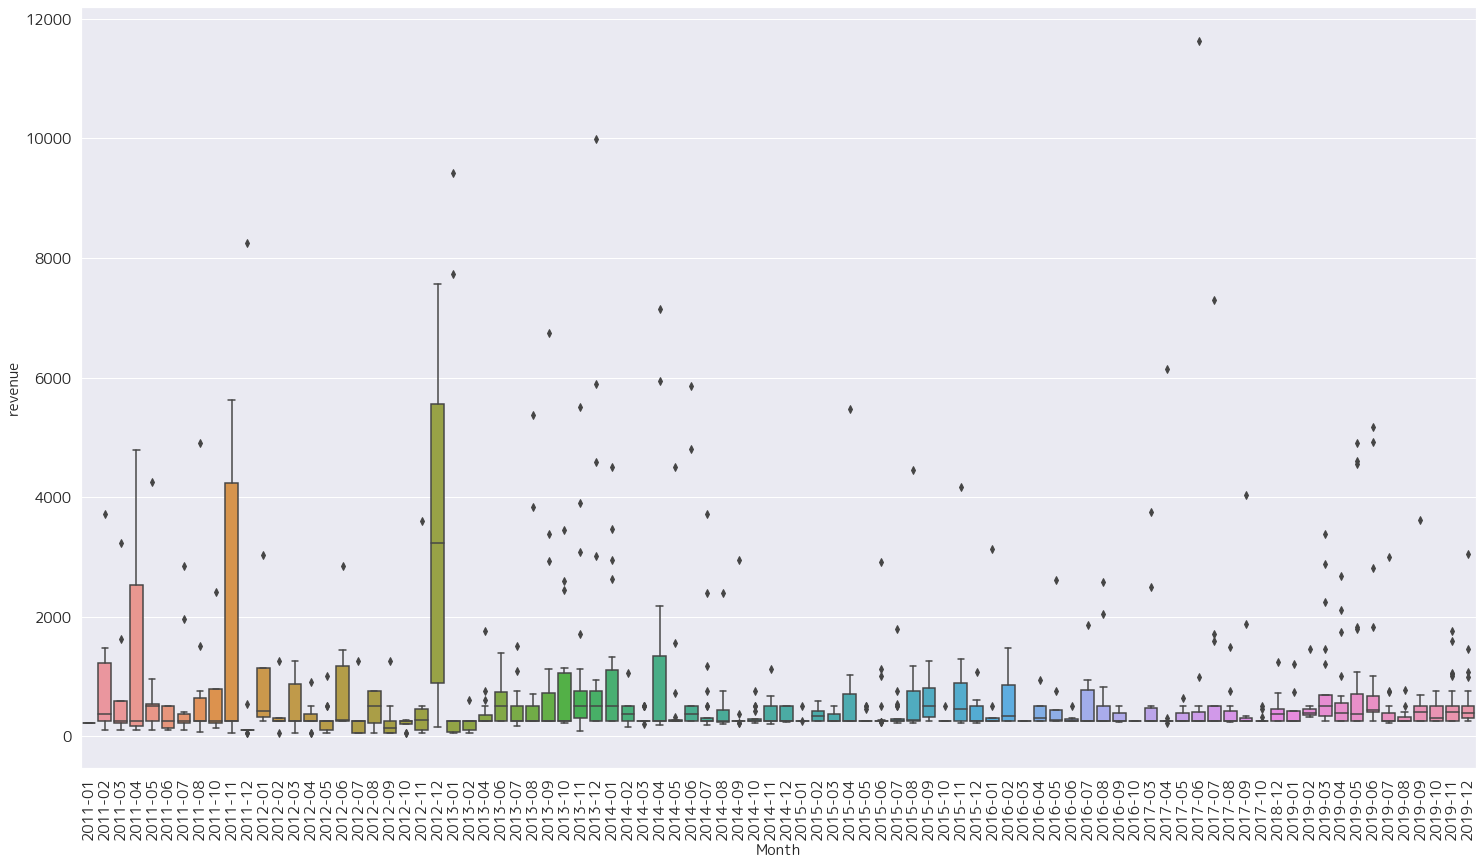

In [100]:
plt.figure(figsize=(25,14))
sns.boxplot(x='month_year',y='total_price',data=df_1nz)
# plt.xticks(rotation = 90)
plt.xticks(fontsize = 15,rotation = 90, weight='bold')
plt.yticks(fontsize = 15)
plt.ylabel('revenue',fontsize = 15)
plt.xlabel('Month',fontsize = 15)

Text(0.5, 0, 'Year')

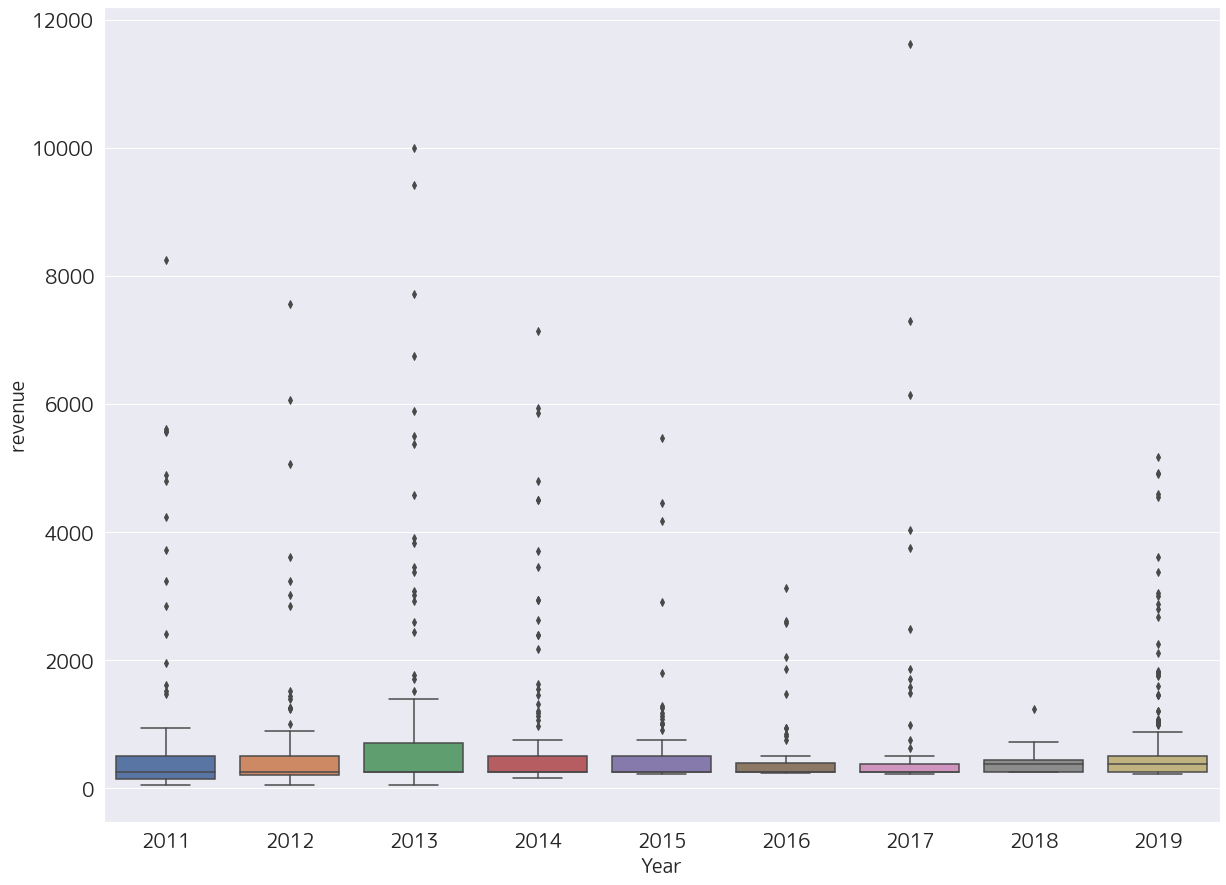

In [101]:
plt.figure(figsize=(20,15))
sns.boxplot(x='year',y='total_price',data=df_1nz)
# plt.xticks(rotation = 90)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('revenue',fontsize = 20)
plt.xlabel('Year',fontsize = 20)

In [102]:
X = np.log(em_series_month).values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# model = ARIMA(np.log(em_series_month), order=(5,1,0))
# results = model.fit()
# pred = results.predict(start='2017-01', dynamic=False)
# y_forecasted = np.exp(pred)
# y_truth = em_series_month['2017-01-01':]
# rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
# mape = mean_absolute_percentage_error(y_truth, y_forecasted)
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
# # plot forecasts against actual outcomes
# plt.xticks(rotation = 90)
# plt.plot(y_forecasted,color='red')
# plt.plot(em_series_month)
# plt.show()
#walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

predicted=6770.137645, expected=5017.050326
predicted=3145.061812, expected=2617.186087
predicted=4357.446775, expected=3822.643043
predicted=2817.058062, expected=8336.871848
predicted=5605.031080, expected=3513.456087
predicted=3959.555486, expected=2525.357609
predicted=4136.313011, expected=9220.357609
predicted=5808.159633, expected=8696.786087
predicted=5233.705085, expected=3127.680326
predicted=4472.498648, expected=15569.321848
predicted=8226.924879, expected=13875.594891
predicted=5606.005164, expected=6304.789130
predicted=7799.070311, expected=8576.336087
predicted=7039.568684, expected=3800.529130
predicted=5143.583619, expected=10403.580652
predicted=10113.347482, expected=6568.071848
predicted=4656.422644, expected=3803.811522
predicted=6393.342506, expected=17120.177609
predicted=7917.173392, expected=13502.744565
predicted=6209.490032, expected=27214.507609
predicted=13818.354063, expected=24775.182174
predicted=9201.496951, expected=14612.698587
predicted=14197.586043

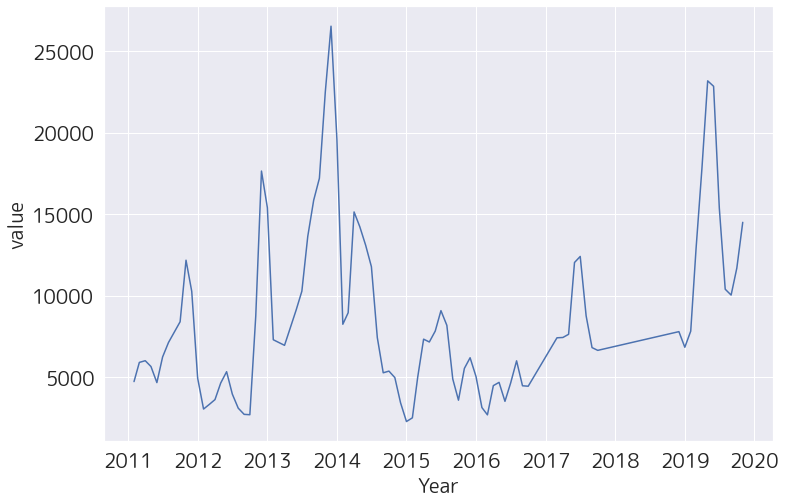

In [103]:
decomposition = seasonal_decompose(em_series_month, model='additive',period = 2)
plt.figure(figsize=(12,8))
plt.xticks(fontsize = 20, rotation = 0)
plt.yticks(fontsize = 20, rotation = 0)
plt.xlabel('Year',fontsize = 20)
plt.ylabel('value',fontsize = 20)
plt.plot(decomposition.trend)

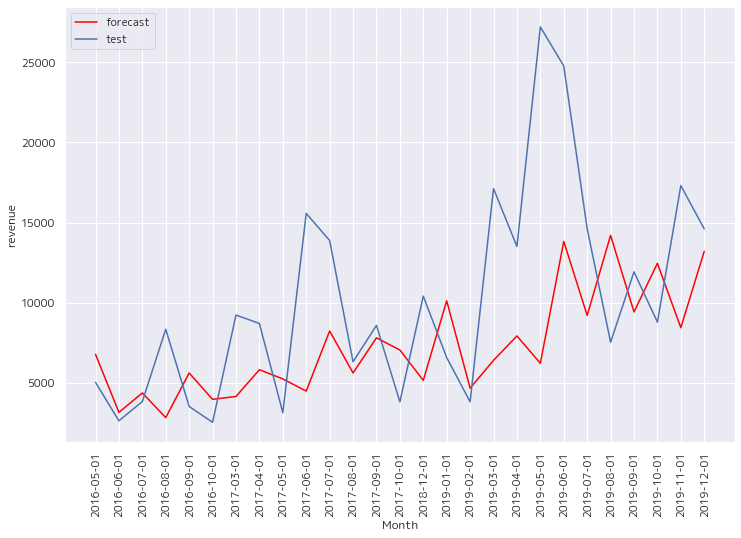

In [105]:
df_sum_month.reset_index(inplace=True)
df_sum_month['month_year'] = df_sum_month['month_year'].astype(str)
list_datetime = list(df_sum_month['month_year'][size:len(X)])
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
plt.xlabel('Month')
plt.ylabel('revenue')
sns.lineplot(x=list_datetime,y='total_price',data=df_sum_month[size:len(X)])
plt.legend(loc='upper left', labels=['forecast','test'])


In [110]:
X = np.log(em_series_year).values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# model = ARIMA(np.log(em_series_month), order=(5,1,0))
# results = model.fit()
# pred = results.predict(start='2017-01', dynamic=False)
# y_forecasted = np.exp(pred)
# y_truth = em_series_month['2017-01-01':]
# rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
# mape = mean_absolute_percentage_error(y_truth, y_forecasted)
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
# # plot forecasts against actual outcomes
# plt.xticks(rotation = 90)
# plt.plot(y_forecasted,color='red')
# plt.plot(em_series_month)
# plt.show()
#walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

predicted=66001.314856, expected=69171.395109
predicted=74901.791907, expected=10403.580652
predicted=38537.100406, expected=167732.336630
RMSE: 83389.603
MAPE: 2.339


In [81]:
import math
min_aic = math.inf
list_param = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
            mod = SARIMAX(em_series_year,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            if results.aic < min_aic:
                min_aic  = results.aic
                list_param.clear()
                list_param.append(param)
                list_param.append(param_seasonal)
print(min_aic,list_param)

NameError: name 'pdq' is not defined

In [166]:
mod =SARIMAX(em_series_month,
                                order=(5, 1, 1),
                                seasonal_order=(0, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1997      0.476      0.420      0.675      -0.733       1.132
ar.L2         -0.2721      0.187     -1.455      0.146      -0.639       0.094
ar.L3          0.0097      0.296      0.033      0.974      -0.570       0.590
ar.L4         -0.1283      0.195     -0.659      0.510      -0.510       0.253
ar.L5         -0.0740      0.227     -0.326      0.744      -0.518       0.370
ma.L1         -0.6228      0.438     -1.423      0.155      -1.481       0.235
ma.S.L12      -0.2980      0.131     -2.283      0.022      -0.554      -0.042
sigma2      3.462e+07   1.29e-08   2.69e+15      0.000    3.46e+07    3.46e+07


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


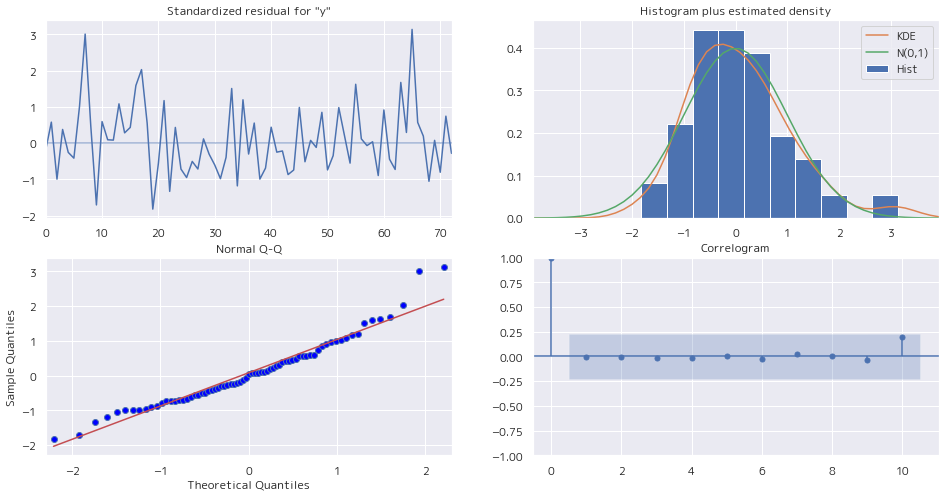

In [167]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

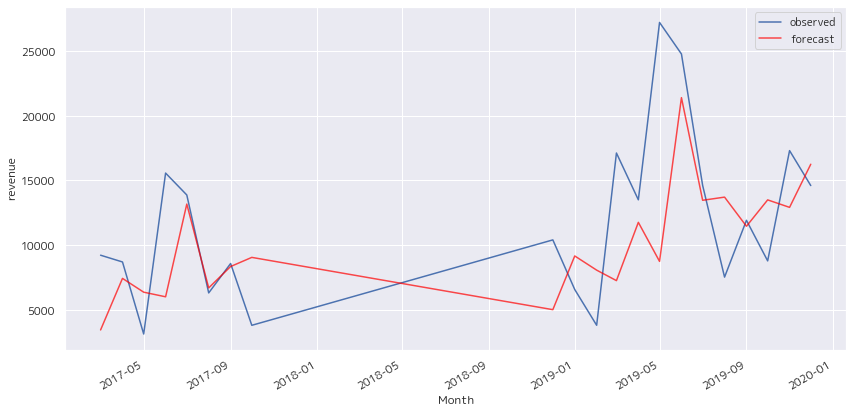

In [168]:
pred = results.get_prediction(start='2017-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_month['2017-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [169]:
y_forecasted = pred.predicted_mean
y_truth = em_series_month['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 6000.558
MAPE: 0.445


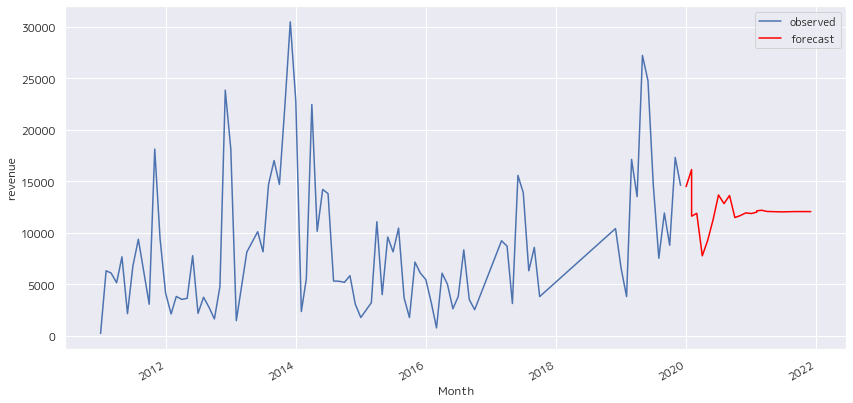

In [170]:
index = pd.to_datetime(['2020-01-01', '2020-02-01','2020-03-01','2020-02-01','2020-04-01','2020-05-01',
                        '2020-06-01','2020-07-01','2020-08-01','2020-09-01','2020-10-01','2020-11-01','2020-12-01',
                       '2021-01-01', '2021-02-01','2021-03-01','2021-02-01','2021-04-01','2021-05-01',
                        '2021-06-01','2021-07-01','2021-08-01','2021-09-01','2021-10-01','2021-11-01','2021-12-01'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_month.plot(label='observed', figsize=(14, 7),)
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [171]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2020-01-01,14474.766313
2020-02-01,16133.903268
2020-03-01,11881.132525
2020-02-01,11606.695351
2020-04-01,7759.910727
2020-05-01,9244.378878
2020-06-01,11292.254976
2020-07-01,13665.816498
2020-08-01,12825.764975
2020-09-01,13617.272395


In [238]:
mod =SARIMAX(em_series_year,
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 1, 4),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9611    207.005     -0.005      0.996    -406.684     404.762
ma.L1          0.3627    607.139      0.001      1.000   -1189.608    1190.333
ar.S.L4       -1.2408    520.051     -0.002      0.998   -1020.522    1018.041
ma.S.L4       -0.2869    189.657     -0.002      0.999    -372.008     371.434
sigma2       4.09e+09   1.88e-05   2.17e+14      0.000    4.09e+09    4.09e+09


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
D:\Software\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Software\Anaconda\lib\site-packages\statsmod

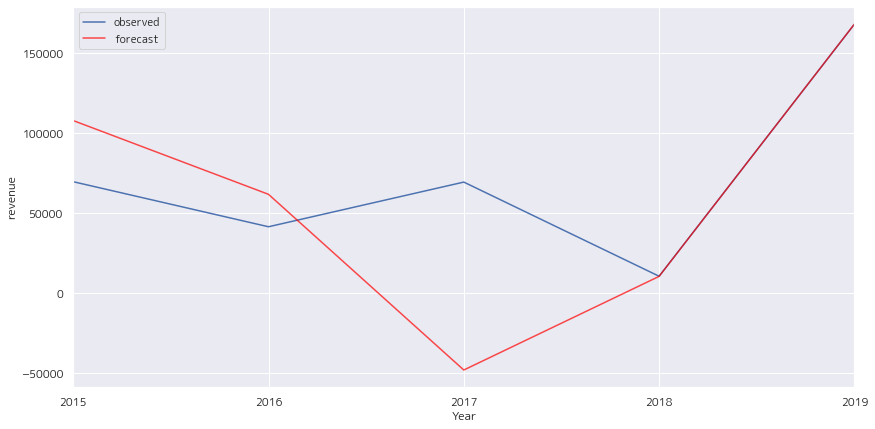

In [239]:
pred = results.get_prediction(start='2015-01-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_year['2015-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [241]:
y_forecasted = pred.predicted_mean
y_truth = em_series_year['2015-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 55903.013
MAPE: 0.549


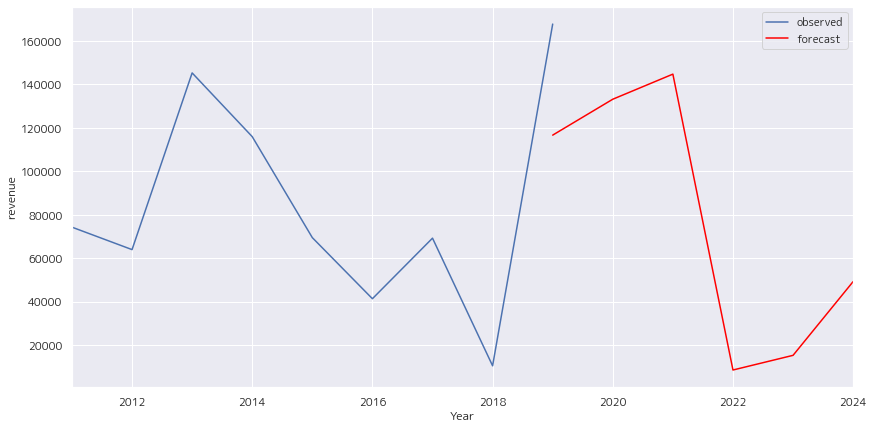

In [245]:
index = pd.to_datetime(['2019', '2020','2021','2022','2023','2024'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_year.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [246]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2019-01-01,116603.072194
2020-01-01,133137.294091
2021-01-01,144686.232663
2022-01-01,8467.936367
2023-01-01,15220.660928
2024-01-01,49185.753749


# Engine Model 4G64

In [410]:
df_sum_day = df_1g.groupby(['Register Date'])['total_price'].sum().reset_index()
df_sum_month = df_1g.groupby(['month_year'])['total_price'].sum().reset_index()
df_sum_year = df_1g.groupby(['year'])['total_price'].sum().reset_index()
df_sum_month['month_year'] = pd.to_datetime(df_sum_month['month_year'],format='%Y-%m')
df_sum_month.set_index('month_year',inplace = True)
# df_sum_day['Register Date'] = df_sum_day['Register Date'].astype(str)
df_sum_year['year'] = pd.to_datetime(df_sum_year['year'],format='%Y')
em_series_month =  pd.Series(df_sum_month.total_price.values,index=df_sum_month.index)
em_series_year =  pd.Series(df_sum_year.total_price.values,index=df_sum_year['year'])
em_series = pd.Series(df_sum_day.total_price.values,index=df_sum_day['Register Date'])
em_series_sample = pd.Series(df_1g.total_price.values,index=df_1g['Register Date'])

In [411]:
len(train)

65

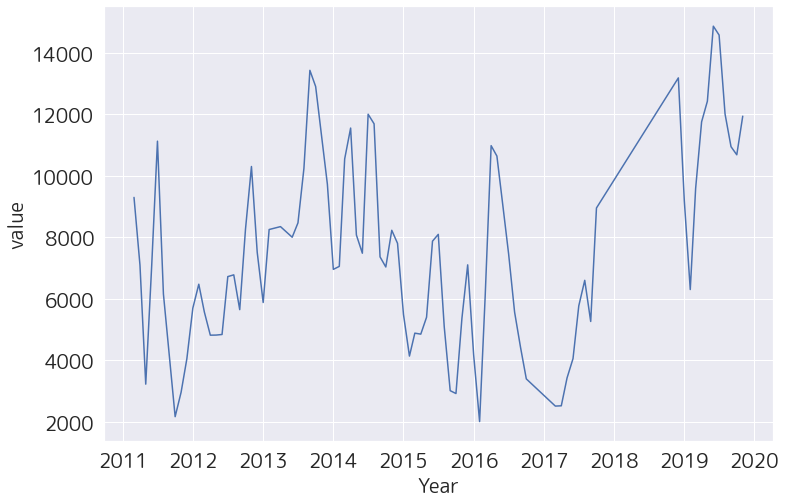

In [412]:
decomposition = seasonal_decompose(em_series_month, model='additive',period = 2)
plt.figure(figsize=(12,8))
plt.xticks(fontsize = 20, rotation = 0)
plt.yticks(fontsize = 20, rotation = 0)
plt.xlabel('Year',fontsize = 20)
plt.ylabel('value',fontsize = 20)
plt.plot(decomposition.trend)

In [413]:
X = np.log(em_series_month).values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

predicted=2574.867079, expected=6853.341429
predicted=3641.460988, expected=11590.853571
predicted=4844.884165, expected=6096.698214
predicted=7718.258323, expected=6062.557500
predicted=6050.939764, expected=4076.512143
predicted=6642.071317, expected=3482.402857
predicted=5526.173260, expected=2564.062143
predicted=5384.767080, expected=1460.426786
predicted=4675.582601, expected=4621.878929
predicted=4043.254313, expected=3031.768214
predicted=4081.269066, expected=5559.536429
predicted=3928.851941, expected=8953.565714
predicted=5256.144633, expected=2955.541429
predicted=5192.625420, expected=6209.051429
predicted=5348.232115, expected=20453.734643
predicted=5114.238572, expected=5625.939643
predicted=5220.841274, expected=5069.748929
predicted=6687.966408, expected=9460.604286
predicted=6508.445330, expected=14397.803571
predicted=4875.682133, expected=8774.662857
predicted=6115.473062, expected=17757.946786
predicted=7166.921557, expected=15175.009643
predicted=7838.161736, expe

In [414]:
# df_sum_month.reset_index(inplace=True)
# df_sum_month['month_year'] = df_sum_month['month_year'].astype(str)
list_datetime = list(df_sum_month['month_year'][40:len(X)])
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
plt.xlabel('Month')
plt.ylabel('revenue')
sns.lineplot(x=list_datetime,y='total_price',data=df_sum_month[40:len(X)])
plt.legend(loc='upper left', labels=['forecast','test'])

KeyError: 'month_year'

In [415]:
import math
min_aic = math.inf
list_param = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
            mod = SARIMAX(em_series_month,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            if results.aic < min_aic:
                min_aic  = results.aic
                list_param.clear()
                list_param.append(param)
                list_param.append(param_seasonal)
print(min_aic,list_param)

NameError: name 'pdq' is not defined

In [416]:
mod =SARIMAX(em_series_month,
                                order=(5, 0, 1),
                                seasonal_order=(5, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0168      0.825     -0.020      0.984      -1.634       1.600
ar.L2         -0.0582      0.498     -0.117      0.907      -1.034       0.918
ar.L3          0.4702      0.403      1.166      0.244      -0.320       1.261
ar.L4          0.3367      0.644      0.523      0.601      -0.925       1.598
ar.L5          0.2589      0.917      0.282      0.778      -1.538       2.056
ma.L1          0.9573      1.048      0.913      0.361      -1.097       3.011
ar.S.L12      -0.1907      0.882     -0.216      0.829      -1.919       1.538
ar.S.L24      -0.2075      0.609     -0.341      0.733      -1.401       0.986
ar.S.L36      -0.2396      0.674     -0.356      0.722      -1.560       1.081
ar.S.L48       0.0966      0.571      0.169      0.866      -1.022       1.215
ar.S.L60       0.5282      0.458      1.153      0.2

D:\Software\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


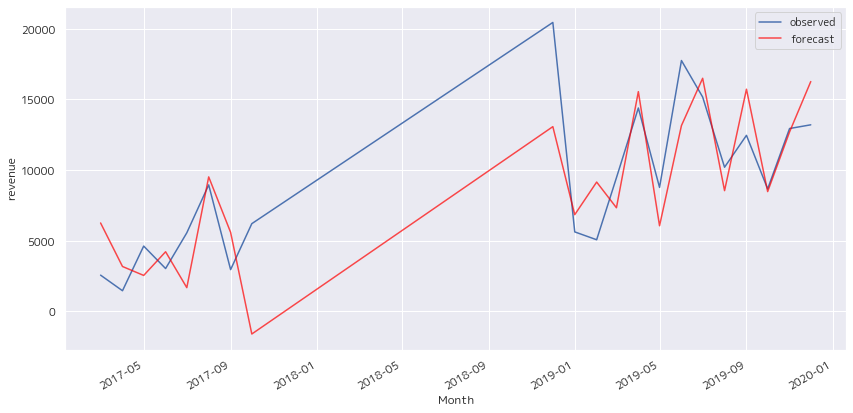

In [417]:
pred = results.get_prediction(start='2017-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_month['2017-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [418]:
y_forecasted = pred.predicted_mean
y_truth = em_series_month['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 3361.965
MAPE: 0.448


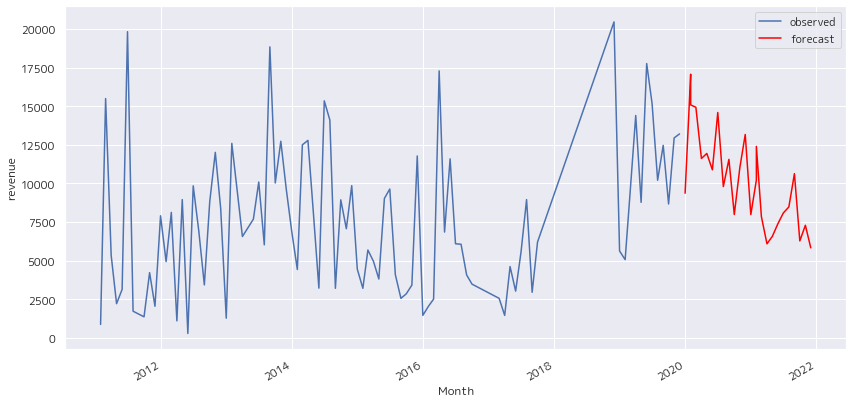

In [419]:
index = pd.to_datetime(['2020-01-01', '2020-02-01','2020-03-01','2020-02-01','2020-04-01','2020-05-01',
                        '2020-06-01','2020-07-01','2020-08-01','2020-09-01','2020-10-01','2020-11-01','2020-12-01',
                       '2021-01-01', '2021-02-01','2021-03-01','2021-02-01','2021-04-01','2021-05-01',
                        '2021-06-01','2021-07-01','2021-08-01','2021-09-01','2021-10-01','2021-11-01','2021-12-01'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_month.plot(label='observed', figsize=(14, 7),)
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [278]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2020-01-01,5570.139239
2020-02-01,5035.918188
2020-03-01,6894.467680
2020-02-01,8051.093708
2020-04-01,7172.201079
2020-05-01,9308.264488
2020-06-01,7611.892148
2020-07-01,6973.205540
2020-08-01,11073.040793
2020-09-01,6223.419293


In [293]:
mod =SARIMAX(em_series_year,
                                order=(1, 0, 0),
                                seasonal_order=(1, 0, 1, 2),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2668      0.195      6.501      0.000       0.885       1.649
ar.S.L2       -0.8172      1.128     -0.725      0.469      -3.028       1.394
ma.S.L2       -2.6249      3.893     -0.674      0.500     -10.256       5.006
sigma2      2.044e+09   7.89e-10   2.59e+18      0.000    2.04e+09    2.04e+09


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


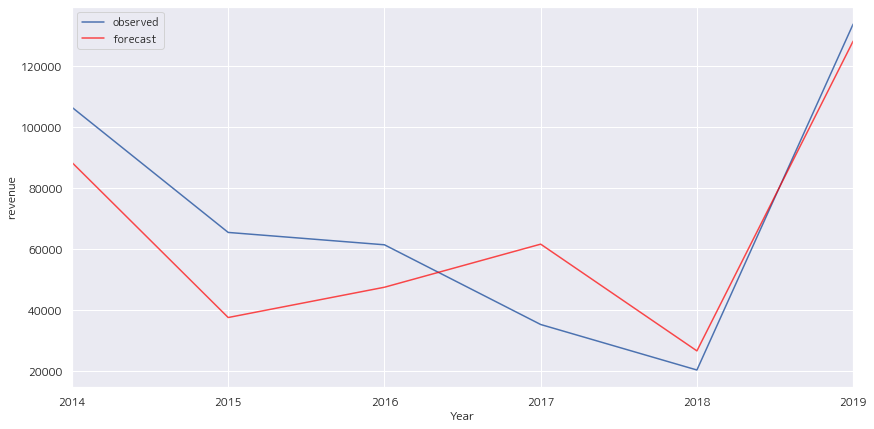

In [294]:
pred = results.get_prediction(start='2014-01-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_year['2014-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [295]:
y_forecasted = pred.predicted_mean
y_truth = em_series_year['2014-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 18525.942
MAPE: 0.319


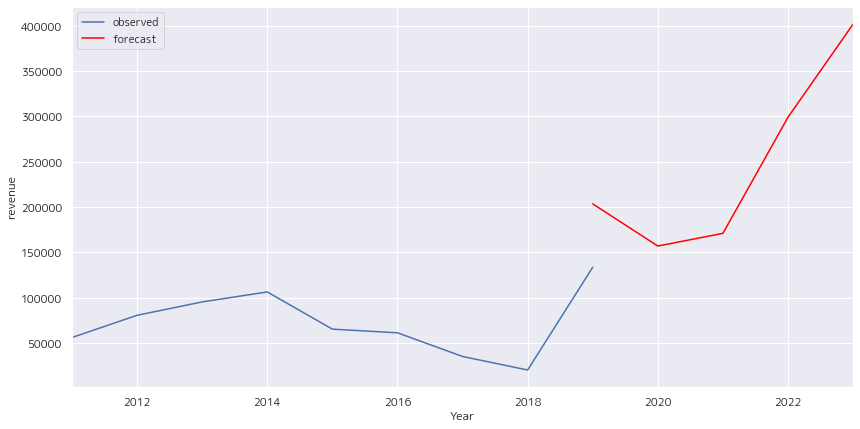

In [297]:
index = pd.to_datetime(['2019', '2020','2021','2022','2023'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_year.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [298]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2019-01-01,203545.985143
2020-01-01,157055.935833
2021-01-01,171089.645735
2022-01-01,299123.496028
2023-01-01,401721.493485


# Engine Model 4G15

In [299]:
df_sum_day = df_fp.groupby(['Register Date'])['total_price'].sum().reset_index()
df_sum_month = df_fp.groupby(['month_year'])['total_price'].sum().reset_index()
df_sum_year = df_fp.groupby(['year'])['total_price'].sum().reset_index()
df_sum_month['month_year'] = pd.to_datetime(df_sum_month['month_year'],format='%Y-%m')
df_sum_month.set_index('month_year',inplace = True)
# df_sum_day['Register Date'] = df_sum_day['Register Date'].astype(str)
df_sum_year['year'] = pd.to_datetime(df_sum_year['year'],format='%Y')
em_series_month =  pd.Series(df_sum_month.total_price.values,index=df_sum_month.index)
em_series_year =  pd.Series(df_sum_year.total_price.values,index=df_sum_year['year'])
em_series = pd.Series(df_sum_day.total_price.values,index=df_sum_day['Register Date'])
em_series_sample = pd.Series(df_fp.total_price.values,index=df_fp['Register Date'])

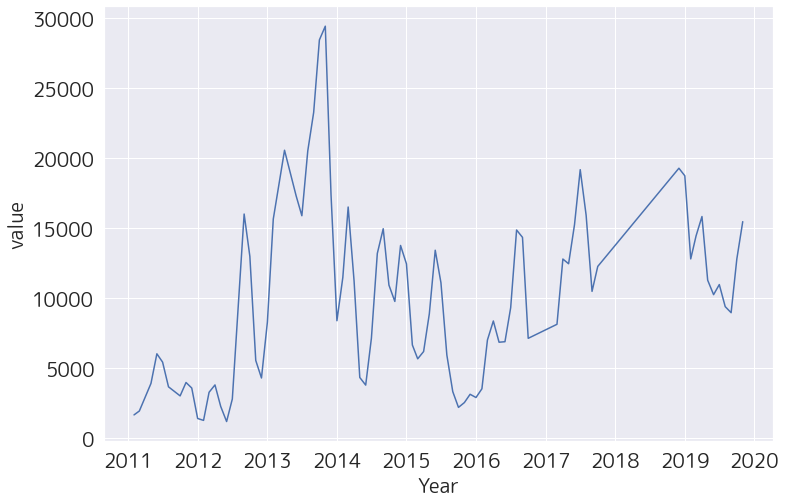

In [300]:
decomposition = seasonal_decompose(em_series_month, model='additive',period = 2)
plt.figure(figsize=(12,8))
plt.xticks(fontsize = 20, rotation = 0)
plt.yticks(fontsize = 20, rotation = 0)
plt.xlabel('Year',fontsize = 20)
plt.ylabel('value',fontsize = 20)
plt.plot(decomposition.trend)

In [301]:
X = np.log(em_series_month).values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

predicted=8708.791692, expected=2627.878723
predicted=4462.248436, expected=5275.037234
predicted=5768.590670, expected=19307.888723
predicted=12863.729715, expected=7266.704255
predicted=6387.226670, expected=15968.838298
predicted=6750.246244, expected=21787.124894
predicted=10933.888853, expected=17190.265745
predicted=11320.497449, expected=7536.544681
predicted=8122.105212, expected=9645.318298
predicted=10497.916037, expected=22217.625106
predicted=14235.771023, expected=23064.486170
predicted=12384.437065, expected=6635.917872
predicted=7303.131286, expected=14863.157021
predicted=11920.109414, expected=21417.507447
predicted=15175.205068, expected=5624.656596
predicted=7727.092101, expected=12437.237660
predicted=9868.350461, expected=10469.603191
predicted=10421.702832, expected=10479.294894
predicted=9294.740730, expected=6108.617234
predicted=6993.845322, expected=13111.173404
predicted=10018.317019, expected=18853.944255
predicted=10813.803587, expected=11039.377660
RMSE: 7

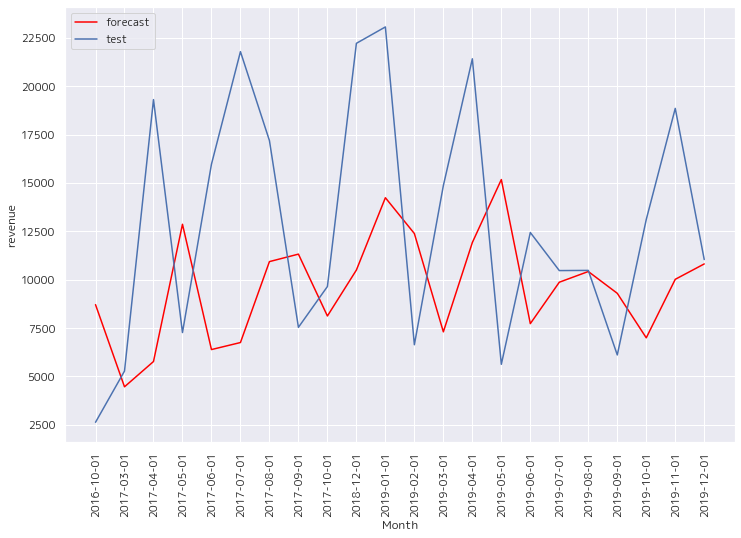

In [302]:
df_sum_month.reset_index(inplace=True)
df_sum_month['month_year'] = df_sum_month['month_year'].astype(str)
list_datetime = list(df_sum_month['month_year'][size:len(X)])
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
plt.xlabel('Month')
plt.ylabel('revenue')
sns.lineplot(x=list_datetime,y='total_price',data=df_sum_month[size:len(X)])
plt.legend(loc='upper left', labels=['forecast','test'])

In [407]:
mod =SARIMAX(em_series_month,
                               order=(5, 0, 1),
                                seasonal_order=(5, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2668      0.823      1.540      0.124      -0.345       2.879
ar.L2         -1.2355      1.080     -1.144      0.253      -3.353       0.882
ar.L3          1.0705      0.991      1.080      0.280      -0.872       3.013
ar.L4         -0.5301      0.951     -0.557      0.577      -2.395       1.334
ar.L5          0.4481      0.695      0.645      0.519      -0.913       1.810
ma.L1         -0.7234      0.873     -0.829      0.407      -2.435       0.988
ar.S.L12      -0.2464     11.074     -0.022      0.982     -21.951      21.459
ar.S.L24       0.2940      3.557      0.083      0.934      -6.679       7.266
ar.S.L36      -0.1970      3.405     -0.058      0.954      -6.871       6.477
ar.S.L48       0.2530      2.234      0.113      0.910      -4.125       4.631
ar.S.L60      -0.0274      2.374     -0.012      0.9

D:\Software\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


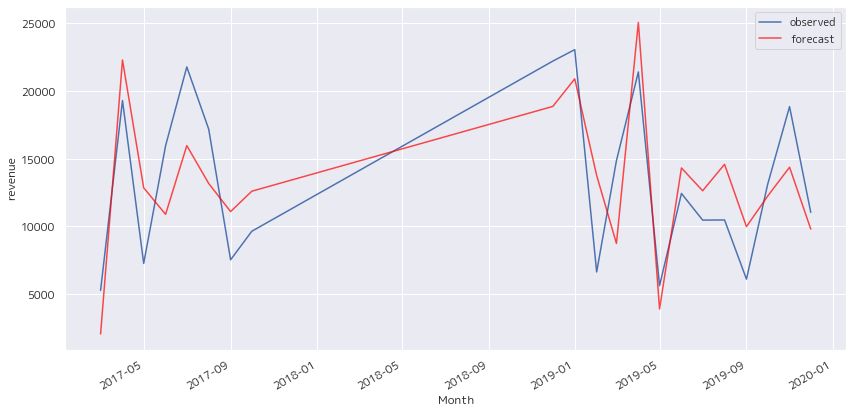

In [408]:
pred = results.get_prediction(start='2017-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_month['2017-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [409]:
y_forecasted = pred.predicted_mean
y_truth = em_series_month['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 3968.985
MAPE: 0.340


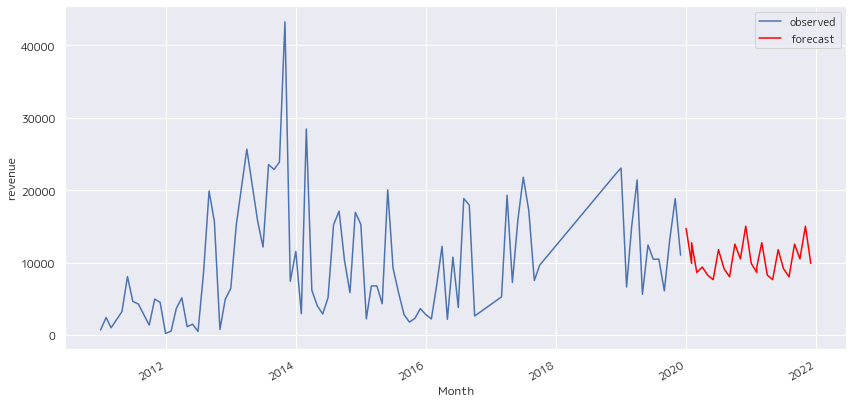

In [309]:
index = pd.to_datetime(['2020-01-01', '2020-02-01','2020-03-01','2020-02-01','2020-04-01','2020-05-01',
                        '2020-06-01','2020-07-01','2020-08-01','2020-09-01','2020-10-01','2020-11-01','2020-12-01',
                       '2021-01-01', '2021-02-01','2021-03-01','2021-02-01','2021-04-01','2021-05-01',
                        '2021-06-01','2021-07-01','2021-08-01','2021-09-01','2021-10-01','2021-11-01','2021-12-01'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_month.plot(label='observed', figsize=(14, 7),)
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [310]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2020-01-01,14733.149351
2020-02-01,9890.443642
2020-03-01,8653.698340
2020-02-01,12752.267871
2020-04-01,9391.139715
2020-05-01,8285.278164
2020-06-01,7652.703339
2020-07-01,11787.637923
2020-08-01,9170.123320
2020-09-01,8045.970397


In [402]:
mod =SARIMAX(em_series_year,
                                order=(1, 0, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4192      0.191      7.422      0.000       1.044       1.794
ma.L1         -1.7587      0.489     -3.598      0.000      -2.717      -0.801
sigma2      2.924e+09   1.99e-10   1.47e+19      0.000    2.92e+09    2.92e+09


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


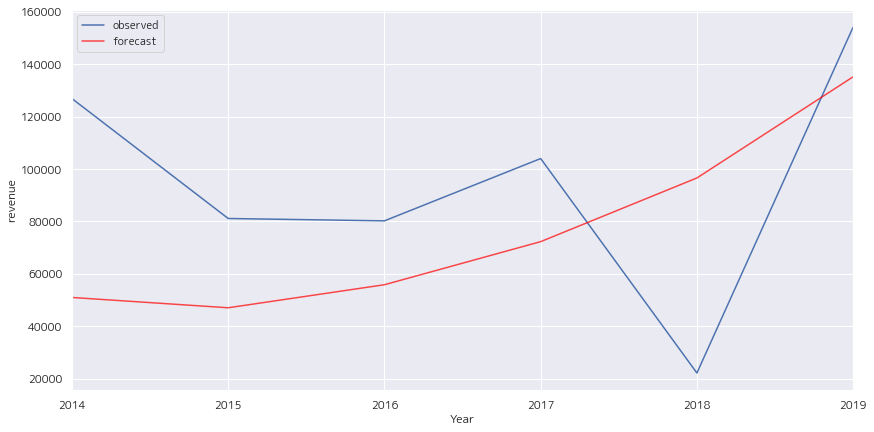

In [403]:
pred = results.get_prediction(start='2014-01-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_year['2014-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [404]:
y_forecasted = pred.predicted_mean
y_truth = em_series_year['2014-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 48978.735
MAPE: 0.849


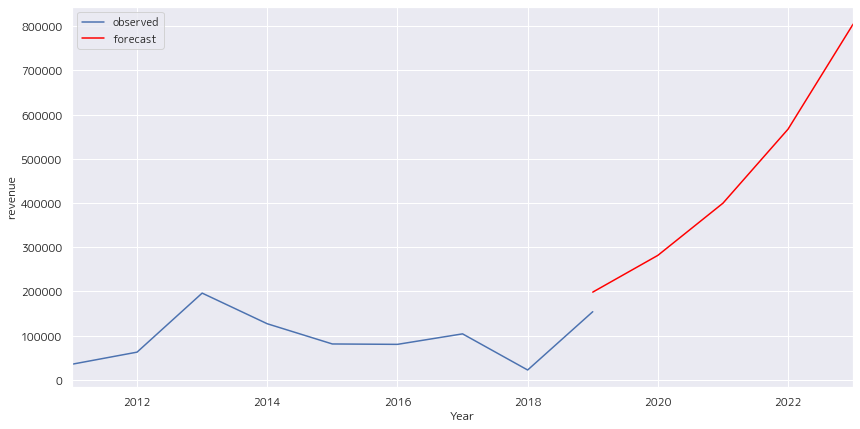

In [405]:
index = pd.to_datetime(['2019', '2020','2021','2022','2023'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_year.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [406]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2019-01-01,198405.714952
2020-01-01,281571.484320
2021-01-01,399597.868445
2022-01-01,567097.399269
2023-01-01,804807.747120
